# Ranked Strategic Classification 🦚

⚠️ Warning - we train many small models in this notebook for the different experiments so don't try to run this yourself. Runtime >20 minutes. 

## 1. Introduction

In our project we tackle the problem of Strategic classification with user dependant responses. 

We introduce user dependance through competition on $k$ available spots which are given to the top-k rated users.

This problem appears in our daily life in multiple places such as acceptance into universities and job interviews, where the users compete for a few available spots.

These users are strategic, meaning they can improve their rating by changing their features to move up the ranking and get accepted. In the example of a job interview, they can for example create a specialized CV which they know will help them in getting the job.

### 1.1 Goals
In this project, our goals are:

🦚 Developing a system capable of coping with contest behavior.

🦚 Deploying the system on toy example with synthetic data.

🦚 Exploring why the system works/fails.

🦚 Exploring effects of different contests (through contest parameters we define).

🦚 Exploring potential pitifalls of the system, where it fails and where it succeeds.

 ### 1.2 Setting
- Time is assumed to be discrete and denoted by $t\in\{0,1,...\}$
- Each user $i$ has initial features $x_i(0)\in \mathbb{R}^d$
- Each user $i$ updates his features at each time $t$ with a function $x_i(t) = \Delta_h(x_i(0))$.
  
<ins>Note:</ins> For simplification, the user always updates his features based on his features at $t=0$.
- The set of user features at time $t$ is denoted by $X_t$
- Each user has a ground truth rating $r(x_i(0))$
- The model predicted ratings are denoted by $r_{\theta}(x_i(t))$. We train a model to predict the true ratings using an MSE loss $\ell(r(x_i(0)),r_{\theta}(x_i(t))) = \lVert r(x_i(0)) - r_{\theta}(x_i(t)) \rVert ^2 $. 
- Denote the sorted indices of the users based on $r_{\theta}(x_i(t))$ by $s_i(t) = \text{argsort}(\{r_\theta(x(t))\}_{x(t)\in X_t})[i]$

Given all of the users and their features, the system predicts the rating for each user, $r_\theta(x_i(t))$, and accepts the top-$k$ rated users $\{x_{s_1(t)},...,x_{s_k(t)}\}$. 



In [1]:
%matplotlib notebook
%matplotlib inline
import cvxpy as cp
import copy
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
import pandas as pd
import time
from torch.utils.data import TensorDataset, DataLoader
import math
import os
from sklearn.metrics import ndcg_score, precision_score, recall_score

X_LOWER_BOUND = -10
X_UPPER_BOUND = 10
SEED = 12
VERBOSE = False

torch.set_default_dtype(torch.float64)
torch.manual_seed(SEED)
np.random.seed(SEED)


## make plots prettier 
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'

### 1.3 Strategic Behavior Model

We model the behavior based on the paper: *S. Levanon, N. Rosenfeld: "Strategic Classification Made Practical", 2021*

We assume a behavioral model for the user strategic response $\Delta_h(\cdot)$. Given the ratings at time $t$ we calculate 2 thresholds:

$$
T_{low} = r_\theta(x_{s_k(t)}(t)), \quad T_{high} = r_\theta(x_{s_{k'}(t)}(t)) 
$$

Where $k'< k$ is a positive integer. These thresholds are used to model the behavioral responses. 

We hypothesize that users will not be satisfied by barely passing the low threshold and will want acceptance confidence, i.e. will want to be further from the lower acceptance rate and closer to some higher rating threshold. Using this we design the following reward function: 

$$h(r;\phi) = q\cdot\sigma^*_{\tau}\left(\frac{r-T_{low}}{\tau_{low}}\right) + (1-q)\cdot\sigma^*_{\tau}\left(\frac{r-T_{high}}{\tau_{high}}\right)$$

Where $q\in[0,1]$, and $\sigma(\cdot)$ is a sigmoid function that will be discussed in the CCP section. This gives a reward $q$ for acceptance and the rest is given for passing the higher threshold. $\phi = \{ T_{low},T_{high}, \tau_{low}, \tau_{high}, q\} $ denotes the set of all behavioral parameters which impact the reward function $h$.

The $\tau$ parameters express the softness of threshold; small $\tau$ will give a step like reward and large $\tau$ will give a smoother reward. In the code with use $\text{slope}=\tau^{-1}$ to control this property.

The user responses are modeled as 

$$\Delta_h(x) = \underset{x'}{\text{argmax }} h(r_\theta(x');\phi) - c(x,x')$$

Where $c(\cdot,\cdot)$ is a convex cost function for feature change, we use squared Euclidean distance.

This function for different parameters is plotted below to help understand its properties.

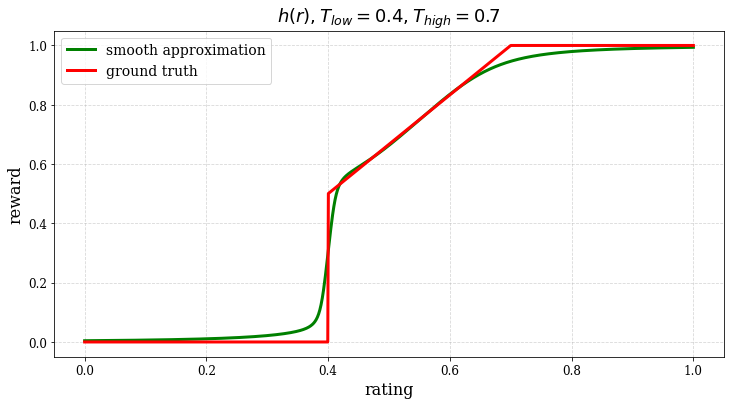

In [9]:
# plotting how the function looks for different contest parameters
def ccp_sigmoid(x, tau):
  return 0.5*np.sqrt(((x/tau + 1) ** 2) + 1) - 0.5*np.sqrt(((x/tau - 1) ** 2) + 1)

def ccp_smooth_f(x, slope_low=50, slope_high=20, T_low=0.4, T_high=0.7, q=0.5):
  return q*ccp_sigmoid(x - T_low, tau=1/slope_low) + (1-q)*ccp_sigmoid(x - T_high, tau=1/slope_high)

def non_smooth_f(r,thresh_low=0.4,thresh_high=0.7, q=0.5):
  h = np.zeros(r.shape)
  h[r > thresh_high] = 1
  mid_idx = np.logical_and(r <= thresh_high, r >= thresh_low)
  h[mid_idx] = (r[mid_idx] - thresh_low)/(thresh_high - thresh_low)*(1-q) + q
  return h

fig, ax = plt.subplots(1,1,figsize=(12,6))
r = np.linspace(0, 1, 1000)
ax.plot(r,0.5*ccp_smooth_f(r, slope_low=100, slope_high=10, T_high=0.55) + 0.5,color='green', label='smooth approximation')
ax.plot(r,non_smooth_f(r, thresh_high=0.7),color='red', label='ground truth')
# ax.plot(r,ccp_smooth_f(r, slope_low=10, slope_high=30),color='purple', label="$\mathrm{slope}_{low}=10$, $\mathrm{slope}_{high}=30$, $q=0.5$")
# ax.plot(r,(ccp_smooth_f(r, slope_low=50, slope_high=50, q=0.7)),color='orange', label='$\mathrm{slope}_{low}=50$, $\mathrm{slope}_{high}=50$, $q=0.7$')
ax.set_xlabel('rating')
ax.set_ylabel('reward')
ax.set_title('$h(r),\t T_{low}=0.4, \t T_{high}=0.7$')
ax.legend()
ax.grid(True)

In the figure above we can see our model for the behavioral response. We present a ground truth model (in red) which is problematic for optimization and a smooth approximation (in green). Both models convey the idea of desired acceptance but lack of statisfaction from laying on the acceptance threshold. That is because the threshold may change from the behavior of other users. 

As presented before both behavioral models contain tunable parameters to account for different behaviors for different constests and for different participants (users) in the contest.

**Note:** The ground truth here is just a conceptual aid we don't explicitly use it anywere in our implementation.


### 1.4 Function Definitions

In this section we implement the score function, as well as a differientiable sigmoid-like function used in the definition of $h$:

$$\sigma_\tau^*(z) = 0.5 \cdot \sqrt{(\tau^{-1}(z-T_{low})+1)^2+1} - 0.5 \cdot \sqrt{(\tau^{-1}(z-T_{high})-1)^2+1}$$

We denote $0.5 \cdot \sqrt{(\tau^{-1}(z-T_{low})+1)^2+1}$ with $f(z)$ and $0.5 \cdot \sqrt{(\tau^{-1}(z-T_{high})-1)^2+1}$ with $g(z)$.

Note that both $f(z)$ and $g(z)$ are convex. The maximization target in the response function $\Delta_h(\cdot)$ is a sum of two such sigmoids minus the cost function.

For a convex cost function the target can be expressed as a difference of convex functions. This property allows us to use the CCP method for the optimization. This is an algorithm that uses local 1st order Taylor approximation at each optimization step for the convex part which makes it affine. This provides a local concave approximation of the target function which allows use of solvers for the maximization.

For further reading on CCP refer to *T. Lipp, S. Boyd: "Variations and extension of the convex-concave procedure", 2015*

The functions below are definitions of the functions that compose the target required for the optimization. They are implemented with CVXPY which is the solver we use.


In [4]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope, T):
    return 0.5*cp.norm(cp.hstack([1, (slope*(score(x, w, b)-T) + 1)]), 2)
    # return 0.5*cp.sqrt(1+cp.square((slope*(score(x, w, b) - T) + 1)))

def g(x, w, b, slope, T):
    res = 0.5*cp.norm(cp.hstack([1, (slope*(score(x, w, b) - T) - 1)]), 2)
    return res

def c(x, r, x_dim, scale):
    return (scale)*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope, T):
    return 0.5*cp.multiply(slope*((slope*(score(x, w, b)-T) + 1)/cp.sqrt((slope*(score(x, w, b)-T) + 1)**2 + 1)), w)

def f_batch(x, w, b, slope, T):
    return cp.norm(cp.vstack([np.ones(x.shape[0]), slope*(score(x, w, b) - T) + 1]), 2, axis=0)

def g_batch(x, w, b, slope, T):
    return cp.norm(cp.vstack([np.ones((1, x.shape[0])), cp.reshape((slope*(score(x, w, b)-T) - 1), (1, x.shape[0]))]), 2, axis=0)

def c_batch(x, r, x_dim, scale):
    return (scale)*cp.square(cp.norm(x-r, 2, axis=1))

def f_derivative_batch(x, w, b, slope, T):
    nablas = 0.5*slope*((slope*(score(x, w, b) - T) + 1)/cp.sqrt((slope*(score(x, w, b) - T) + 1)**2 + 1))
    return cp.reshape(nablas, (nablas.shape[0], 1))@cp.reshape(w, (1, x.shape[1]))

# ------------------------------------- Our added functions -------------------------------------
# summing 2 sigmoids to model initial acceptance and higher acceptance in order to model user behavior of wanting to have some margin from min requirements

def f_tot(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * f(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * f(x, w, b, slope_high, Thresh_high)

def g_tot(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * g(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * g(x, w, b, slope_high, Thresh_high)

def f_tot_derivative(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    f_der = cp.pos(acp_reward) * f_derivative(x, w, b, slope_low, Thresh_low) + cp.pos(1-acp_reward) * f_derivative(x, w, b, slope_high, Thresh_high)
    return f_der

def f_tot_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * f_batch(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * f_batch(x, w, b, slope_high, Thresh_high)

def g_tot_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * g_batch(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * g_batch(x, w, b, slope_high, Thresh_high)

def f_tot_derivative_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    return acp_reward * f_derivative_batch(x, w, b, slope_low, Thresh_low)+ (1-acp_reward) * f_derivative_batch(x, w, b, slope_high, Thresh_high)

# -----------------------------------------------------------------------------------------------

#### Copy of functions in numpy - for line search optimization

In [5]:
def f_np(x, w, b, slope, T):
    s = slope*(score(x, w, b) - T)
    res = 0.5 * np.sqrt(1 + (s + 1) ** 2)
    return res

def g_np(x, w, b, slope, T):
    s = slope*(score(x, w, b) - T)
    res = 0.5 * np.sqrt(1 + (s - 1) ** 2)
    return res

def c_np(x, r, x_dim, scale):
    cost = (scale)*np.sum((x-r) ** 2, 1)
    cost = cost.detach().numpy() if isinstance(cost, torch.Tensor) else cost
    return cost


# ------------------------------------- Our added functions -------------------------------------
# summing 2 sigmoids to model initial acceptance and higher acceptance in order to model user behavior of wanting to have some margin from min requirements

def f_tot_np(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return acp_reward * f_np(x, w, b, slope_low, Thresh_low)+ (1-acp_reward) * f_np(x, w, b, slope_high, Thresh_high)

def g_tot_np(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return acp_reward * g_np(x, w, b, slope_low, Thresh_low)+ (1-acp_reward) * g_np(x, w, b, slope_high, Thresh_high)


# -----------------------------------------------------------------------------------------------

## 2. Implementation
### 2.1 CCP

Defining a CCP class based on the one implemented in the paper referenced above.

Convex-Concave Procedure (in short CCP) is an iterative method for solving optimization problems that are expressed as a difference of convex functions, like the one we have in our problem.

It does so by iterating through a sequence of concave-relaxed problems (using Taylor series to linearize on of the functions), a process that guarantees convergence to local maxima.

As shown in the previous section the response function $\Delta_h$ is a maximization over a difference of convex functions.

In [6]:
class CCP_rank:
    def __init__(self, x_dim, batch_size, funcs, scale):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        self.batch_size = batch_size

        self.x = cp.Variable((batch_size, x_dim))
        self.xt = cp.Parameter((batch_size, x_dim))
        self.r = cp.Parameter((batch_size, x_dim))
        
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1) # bias parameter

        # -------------------- adding our function's params --------------------
        self.slope_low = cp.Parameter(1) # scale of the low threshold sigmoid
        self.slope_high = cp.Parameter(1) # scale of the high threshold sigmoid
        self.T_low = cp.Parameter(1) # low threshold of the sigmoid
        self.T_high = cp.Parameter(1) # high threshold of the sigmoid
        self.acp_reward = cp.Parameter(1) # defines the reward for passing initial threshhold - q in the equations 
        # ----------------------------------------------------------------------

        # -------------------- defining our target function --------------------
        target = cp.diag(self.x@(self.f_derivative(self.xt, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward).T)) - self.g(self.x, self.w,
                        self.b, self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward) - self.c(self.x, self.r,
                        x_dim, scale)
        # # ----------------------------------------------------------------------
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        # define the problem's objective
        self.prob = cp.Problem(cp.Maximize(cp.sum(target)), constraints)

    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.001 and cnt < 100:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)/self.batch_size
        return self.x.value

    def optimize_X(self, X, w, b, slope_low, slope_high, T_low, T_high, acp_reward):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        T_low = T_low.detach().numpy()
        T_high = T_high.detach().numpy()
        

        # converting our params into numpy arrays with 1 value
        slope_low = np.full(1, slope_low)
        slope_high = np.full(1, slope_high)
        T_low = np.full(1, T_low)
        T_high = np.full(1, T_high)
        acp_reward = np.full(1, acp_reward)

        X = X.numpy()

        self.w.value = w
        self.b.value = b
        self.slope_low.value = slope_low
        self.slope_high.value = slope_high
        self.T_low.value = T_low
        self.T_high.value = T_high
        self.acp_reward.value = acp_reward

        # for non-batch usage
        # return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

        # for batch usage
        return torch.from_numpy(self.ccp(X))

### 2.2 Delta 
This module implements a convex optimization layer that returns the strategically updated features of the user based on the response function $\Delta_h(\cdot)$. The use of the convex optimization layer allows differentiation of the update with respect to the model parameters. This includes the strategic behavior in the model optimization. 

In [7]:
class DELTA():

    def __init__(self, x_dim, funcs, scale, slope_low, slope_high, acp_reward):
        self.g = funcs["g"]
        self.c = funcs["c"]

        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        # -------------------- adding our function's params --------------------
        self.slope_low = slope_low # scale of the low threshold sigmoid
        self.slope_high = slope_high # scale of the high threshold sigmoid
        self.T_low = cp.Parameter(1) # low threshold of the sigmoid
        self.T_high = cp.Parameter(1) # high threshold of the sigmoid
        self.acp_reward = acp_reward # the relation between the 2 slopes - defines the reward for passing initial threshhold
        # ----------------------------------------------------------------------

        # -------------------- defining our target function --------------------
        target = self.x@self.f_der-self.g(self.x, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, 
                        self.T_high, self.acp_reward)-self.c(self.x, self.r, x_dim, scale)
        # ----------------------------------------------------------------------
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der, self.T_low, self.T_high], variables=[self.x])
        

    def optimize_X(self, X, w, b, F_DER, T_low, T_high):
        return self.layer(X, w, b, F_DER, T_low, T_high)[0]

### 2.3 Burden
This module implements a convex optimization layer implementing the burden regularization. 
The burden in calculated as the cost payed by the users that should have been accepted. 

$$ \text{Burden}(X_0,X_T,y) = \sum_{i:y_i = 1}\lVert x_i(0) - x_i(T) \rVert^2$$

We add this term to the loss as regularization: 

$$ \text{loss} = \text{RMSE}(r, r_{\text{pred}}) + \lambda\text{Burden}(X_0,X_T, y)$$


***We exprimented with burden but eventually didn't use it for the experiments.***

In [8]:
class BURDEN():
    
    def __init__(self, x_dim, funcs, scale):
        self.c = funcs["c"]
        self.score = funcs["score"]

        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.scale = scale

        target = self.c(self.x, self.r ,x_dim, self.scale)
        constraints = [self.score(self.x, self.w, self.b) >= 0,
                       self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]

        objective = cp.Minimize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b], variables=[self.x])
        
        
    def calc_burden(self, X, Y, w, b):
        """
        tensor to tensor
        """
        Xpos = X[Y==1]
        if len(Xpos) == 0:
            return 0
        Xmin = self.layer(Xpos, w, b)[0]
        return torch.mean(torch.sum((Xpos-Xmin)**2, dim=1))

### 2.4 Model

The model is a simple single linear layer without activation. To model the strategic behavior a convex optimization layer representing $\Delta_h$ is added before the linear layer.

$$ r_\theta(x)=w^Tx+b$$

We allow training with batches, where each batch is a full set of users in a given environment (all competitors) and different batches are simply different competitions. This allows to learn in competitions with a small amount of users without underfitting because of lack of data.


  

In [10]:
# defining special Dataset for batch handling
class CustomDataset(TensorDataset):
    def __init__(self, X, R):
        """
        Args:
            X (torch.Tensor): The input tensor of shape (m, n, d)
            R (torch.Tensor): The label tensor of shape (m, n)
        """
        self.X = X
        self.R = R

    def __len__(self):
        # Return the number of samples (m)
        return self.X.shape[0]

    # note: need to apply the squeeze function in order to remove the extra dimention
    def __getitem__(self, idx):
        # Return a single sample of shape (n, d)
        return self.X[idx], self.R[idx]
    



In [11]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, batch_size, env, strategic=False, lin_search_sample_num=10, burden_reg=0):
        torch.manual_seed(SEED)
        np.random.seed(SEED)

        super(MyStrategicModel, self).__init__()
        self.env = env
        self.x_dim = env.n_features
        self.batch_size = batch_size
        self.train_slope_low, self.train_slope_high = env.slope_low, env.slope_high
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/self.x_dim)*(1-2*torch.rand(self.x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/self.x_dim)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        self.acp_reward = env.acp_reward
        self.strategic = strategic
        # if the model had individual scales, it will train based on the mean scale and not taking into account each and every scale
        scale = env.scale if not isinstance(env.scale, np.ndarray) else env.scale.mean
        self.ccp = CCP_rank(self.x_dim, batch_size, env.funcs_batch, scale)
        self.delta = DELTA(self.x_dim, env.funcs, scale, self.train_slope_low, self.train_slope_high, self.acp_reward)
        self.burden = BURDEN(self.x_dim, env.funcs, scale)
        self.burden_reg = burden_reg # if positive, then use burden regularization if non-positive than there is no regularization 
        self.ccp_time = 0
        self.total_time = 0
        self.lin_search_sample_num = lin_search_sample_num
        
        
    def forward(self, X, use_delta=False, evaluation=False, scales=None):
        if not self.strategic:
            X = X.detach()
        t1 = time.time()
        Xt, X_opt, X_line = self.env.full_dynamic_update(X, self.w, self.b, use_delta=self.strategic, use_lin_search=evaluation, lin_search_sample_num=self.lin_search_sample_num, scales=scales)
        
        self.ccp_time += time.time()-t1
        X_opt = X_opt if self.strategic else Xt
        X_opt = X_line if evaluation else X_opt
        output = self.score(X_opt)
        
        return output, X_opt


    def normalize_weights(self):
        with torch.no_grad():
            norm = torch.sqrt(torch.sum(self.w**2) + self.b**2)
            self.w /= norm
            self.b /= norm
            
    
    def get_wb(self):
        return self.w, self.b
    
    
    def score(self, x):
        return x@self.w + self.b

    def get_f_ders(self, XT, slope):
        nablas = 0.5*slope*((slope*self.score(XT) + 1)/torch.sqrt((slope*self.score(XT) + 1)**2 + 1))
        return torch.reshape(nablas, (len(nablas), 1))@torch.reshape(self.w, (1, len(self.w)))

    def calc_accuracy(self, R, R_pred):
        # calculating acceptance label from ratings
        Y = self.rating_to_accept(R)
        Y_pred = self.rating_to_accept(R_pred)

        # calculating accuracy based on Y and Y_pred
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./len(Y)
        return acc
    
    def calc_burden(self, X_0, X_t, Y, evaluation):
        # i.e., only taking those who were supposed to get accepted
        X_0_pos = X_0[Y==1]
        X_t_pos = X_t[Y==1]
        if len(X_0_pos) == 0:
            return 0
        # and measure how much they moved (although they are supposed to get accepted without effort) in order to get accepted
        if evaluation:
            return torch.mean(torch.sum((X_0_pos-X_t_pos)**2, dim=1)).detach().numpy()
        else:
            return torch.mean(torch.sum((X_0_pos-X_t_pos)**2, dim=1))
    
    # convert rating vector to acceptance
    def rating_to_accept(self, R):
        # calculating Y_pred out of score_pred
        Y = torch.zeros_like(R)
        # getting the top-k values
        top_k_ranking_indices = torch.argsort(R)[-self.env.k:]
        Y[top_k_ranking_indices] = 1
        return Y

    # we use mean squared loss between provided ratings
    def loss(self,X_0, X_T, R, R_pred, Y):
        if self.burden_reg > 0:
            return torch.mean((R-R_pred) ** 2) + self.burden_reg * self.calc_burden(X_0, X_T, Y, evaluation=False)
        else:
            return torch.mean((R-R_pred) ** 2)

    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment

        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)

        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')

        with open(path + "/info.txt", "w") as f:
            f.write(info)

    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()

    # we fit according to score as a proxy to the ranking for simplicity reasons
    def fit(self, path, X, R, Xval, Rval, opt, opt_kwargs={"lr":1e-3}, epochs=100, use_delta=False, verbose=False, callback=None, comment=None, scales_test=None):
        # labels are the true rating 
        # loading the datasets
        # using our dataset which inherits from TensorDataset
        train_dset = CustomDataset(X, R)
        train_loader = DataLoader(train_dset, batch_size=1, shuffle=True)
        test_dset = CustomDataset(Xval, Rval)
        test_loader = DataLoader(test_dset, batch_size=1, shuffle=True)

        # optimizing the NN
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []

        # adding our score metrics (ndcg, precision, recall...)
        our_train_metrics = []
        our_test_metrics = []

        # defining stopping conditions
        # best_val_error = 1
        best_val_loss = np.inf
        consecutive_no_improvement = 0

        # runnning epochs
        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Rbatch in train_loader:
                # need to squeeze in order to remove redundant dimension
                Xbatch = Xbatch.squeeze()
                Rbatch = Rbatch.squeeze()
                
                opt.zero_grad()
                Rbatch_pred, Xbatch_T = self.forward(Xbatch, use_delta=self.strategic)
                # convert ratings to acceptance 
                Y = self.rating_to_accept(Rbatch)
                Y_pred = self.rating_to_accept(Rbatch_pred)
                l = self.loss(Xbatch, Xbatch_T, Rbatch, Rbatch_pred, Y)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    # calculating accuracy
                    e = self.calc_accuracy(Rbatch, Rbatch_pred)

                    # calculating different scores to the ranking
                    our_train_metrics.append({
                        "epoch num" : epoch,
                        "batch num" : batch,
                        "accuracy" : e,
                        "loss" : l.item(),
                        "ndcg" : ndcg_score(np.expand_dims(Rbatch, 0), np.expand_dims(Rbatch_pred, 0)),
                        "precision" : precision_score(Y, Y_pred),
                        "recall" : recall_score(Y, Y_pred),
                        "burden" : self.calc_burden(Xbatch, Xbatch_T, Y, evaluation=False),
                    })
                    
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                total_loss = 0
                total_error = 0
                batch = 0
                for Xbatch, Rbatch in test_loader:
                    Xbatch = Xbatch.squeeze()
                    Rbatch = Rbatch.squeeze()
                    Rval_pred, Xbatch_T = self.forward(Xbatch, evaluation=True, use_delta=False, scales=scales_test)
                    # convert ratings to acceptance
                    Y = self.rating_to_accept(Rbatch)
                    Y_pred = self.rating_to_accept(Rval_pred)
                    val_loss = self.loss(Xbatch, Xbatch_T, Rbatch, Rval_pred, Y).item()
                    total_loss += val_loss
                    val_error = 1-self.calc_accuracy(Rbatch, Rval_pred)
                    total_error += val_error
                    batch += 1

                avg_loss = total_loss/batch
                avg_error = total_error/batch
                # calculating different scores to the ranking
                
                our_test_metrics.append({
                    "epoch num" : epoch,
                    "batch num" : batch,
                    "accuracy" : 1 - avg_error,
                    "loss" : avg_loss,
                    "ndcg" : ndcg_score(np.expand_dims(Rbatch, 0), np.expand_dims(Rval_pred, 0)),
                    "precision" : precision_score(Y, Y_pred),
                    "recall" : recall_score(Y, Y_pred),
                    "burden" : self.calc_burden(Xbatch, Xbatch_T, Y, evaluation=True),
                })
                val_losses.append(avg_loss)
                val_errors.append(avg_error)
                if avg_loss < best_val_loss:
                        consecutive_no_improvement = 0
                        best_val_error = avg_error
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\nslope low: {}\nslope high: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                        time.time()-total_time, epoch, self.batch_size, self.train_slope_low, self.train_slope_high, opt_kwargs["lr"], avg_loss, avg_error)
                        self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                        print("model saved!")

                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break

            t2 = time.time()
            if verbose:
                print("------------- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))

        self.total_time = time.time()-total_time
        print("training time: {} seconds".format(self.total_time))
        # returning our metrics in addition to the errors
        return our_train_metrics, our_test_metrics
    
    
    
    

### 2.5 Data Generation
We generate data in the following procedure:
- user features generated randomly.
- ground truth rating model is $r(x)=u^Tx$, where $u$ is a unit length vector.
- observed noisy ratings $\tilde{r}(x)=r(x)+\epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2_\epsilon)$.

### 2.6 Training Environment

Each training step will include several dynamic iterations (user feature updates) and after that a single update of the system features $\theta$.

Pseudocode of the training:

- until model convergence:
    - for $t = 0:T$
        - Get $T_{low},T_{high}$ from $r_{\theta}(\cdot)$ and $x_t$
        - $x_{t+1} = \Delta_h(x_t,T_{low},T_{high})$
    - Update model based on $x_T,r$
    - $w,b \leftarrow \text{gradient update from rating MSE loss}$

**In test time**, we will evaluate features after the dynamic iteration i.e., $x_T$ and compare the predicted rating to the groud truth ratings.

**In train time**, the model is given initial features for the users $x_0$ and true ratings $r$. The model simulates the features updates based on the models for $\Delta_h$. 

Throughout running the different experiments of this project, we noticed a strange behavior. 

**User feature update with grid Search in test time**
We saw that the users which are above the required threshold tried to change their features in order to get closer to it, and by doing so they hurt their overall rating, and by extension their place in the ranking.
This is of course not logical strategic behavior, since the users only want to improve their rating, regardless of whether they got accepted or not.

We found out through experiments that this problematic behavior stems from optimization errors due to the approximation used in the CCP.
In order to deal with that, we added a grid search to the strategic feature updating process without using the CCP approximation. We sampled values of the strategic objective from all directions which each user can move, and picked the one with the maximum target value. If it had a better rating than the one chosen by the CCP, we chose it over the CCP result. By doing so, the error was fixed.

Note that the model can't perform grid search, as it is not differentiable. Therefore, we only use the grid search at test time, which adds another layer of difficulty/realism for our model to deal with. In the real world we won't neccesarily know the true strategic response model, and will need to approximate it.

In [25]:
class RankingEnv():
    """
    Strategic Classification Environment
    """
    def __init__(self, rating_noise, feature_noise, n_features, k, k_tag, n_users, slope_low, slope_high, acp_reward, funcs, funcs_batch, scale,
                 T_max=5, n_batch=1, uniform_range=2, debug=False, scale_std=0.1, grid_range=0.3, lin_search_sample_num=10):
        self.rating_noise = rating_noise
        self.feature_noise = feature_noise
        self.n_features = n_features
        self.k = k  # k is number of accepted users
        # self.k_tag = k_tag  # k' < k sets the threshold of confidant acceptance
        self.k_tag = (k + k_tag) // 2  # k' < k sets the threshold of confidant acceptance
        self.system_attributes = torch.randn(size=(n_features,), requires_grad=False)*0.1  # u system rating vector, multiplying in 0.1, the scale
        self.system_attributes = self.system_attributes / torch.norm(self.system_attributes)
        
        # system variables 
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/n_features)*(1-2*torch.rand(n_features, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/n_features)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        
        # Delta parameters
        self.slope_low = slope_low # scale of the low threshold sigmoid
        self.slope_high = slope_high # scale of the high threshold sigmoid
        self.acp_reward = acp_reward # the relation between the 2 slopes - defines the reward for passing initial threshhold
        self.scale = scale # cost function scale
        self.scale_std = scale_std # scale std for generating individual scales
        self.n_batch = n_batch # number of train-set batches. diffault is 1 (without batches - 1 for train and 1 for test)
        self.funcs = funcs
        self.funcs_batch = funcs_batch
        self.ccp = CCP_rank(n_features, batch_size=n_users, funcs=funcs_batch, scale=scale)
        self.delta = DELTA(n_features, funcs, scale, slope_low, slope_high, acp_reward)

        # debugging attributes 
        self.debug = debug
        
        # user variables 
        self.n_users = n_users
        self.t = 0  # time indicator
        self.T_max = T_max  #  number of dynamic iterations
        self.uniform_range = uniform_range # the range which we sample from when we generate users from uniform distribution
        self.grid_range = grid_range  # range of the grid search for the grid optimization in test time (in relative part of the uniform range)lin_search_sample_num
        self.lin_search_sample_num = lin_search_sample_num  # number of samples in each axis of grid search
    
    
    # generating dataset for train or test sets. In case of a train-set, generate n_batch datasets. In case of test-set, generate 1 dataset.
    def generate_dataset(self, is_test=False, uniform_dist=False, indivdual_scale=False):
        dataset_num = self.n_batch if not is_test else 1
        X = torch.zeros((dataset_num,self.n_users, self.n_features))
        R = torch.zeros((dataset_num,self.n_users))
        y = torch.zeros((dataset_num,self.n_users))

        for i in range(dataset_num):
            X[i,:,:] = self.generate_users(self.n_users, uniform_dist=uniform_dist)
            R[i,:] = self.rating(X[i,:,:])
            y[i,:] = self.get_true_accepted(X[i,:,:]) 
        # add noise to the features 
        X_noisy = X + torch.randn_like(X) * self.feature_noise
        # for test set specify scale if reqired
        if is_test and indivdual_scale:
            scales = self.scale + torch.randn_like(y) * self.scale_std
            return X_noisy, R, y, scales
        return X_noisy,R,y
        
    def generate_users(self, n_users, uniform_dist=False):
        if uniform_dist:
            return torch.rand(size = (n_users, self.n_features)) * 2 * self.uniform_range - self.uniform_range # random numbers from a uniform distribution [0.1, 0.1]^n_features
        # if not uniform distribution then use normal 
        else:
            return torch.randn(size = (n_users, self.n_features)) * 0.5 * self.uniform_range  # multiplying by half of the uniform range
    
    
    def rating(self, users):
        # return noisy users rating, when the noise is normally distributed
        clean_ratings = users@self.system_attributes.T
        noise = torch.randn_like(clean_ratings) * self.rating_noise # multiplying in the noisyscale
        return clean_ratings + noise
    
    def set_slope(self, slope_low, slope_high):
        self.slope_low = slope_low
        self.slope_high = slope_high
        self.ccp = CCP_rank(self.n_features, batch_size=self.n_users, funcs=self.funcs_batch, scale=self.scale)
        self.delta = DELTA(self.n_features, self.funcs, self.scale, self.slope_low, self.slope_high, self.acp_reward)
        
    def set_scale(self, scale):
        self.scale = scale
        self.ccp = CCP_rank(self.n_features, batch_size=self.n_users, funcs=self.funcs_batch, scale=scale)
        self.delta = DELTA(self.n_features, self.funcs, scale, self.slope_low, self.slope_high, self.acp_reward)
        
    def get_thresh(self, X):
        ranking = self.score(X)
        # reversing the sort into a descending order
        sorted_ranking , _= torch.sort(ranking, descending=True)
        # calculate thresholds from k and k_tag
        return sorted_ranking[self.k-1].reshape(1), sorted_ranking[self.k_tag-1].reshape(1)
    
    # returns ground truth ratings for users
    def get_true_accepted(self, X):
        ranking = self.rating(X)
        acceptance = torch.zeros_like(ranking)
        # sort ranking in descending order
        _ , sorted_indices = torch.sort(ranking, descending=True)
        acceptance[sorted_indices[:self.k]] = 1
        return acceptance
    
    def user_features_update(self, X, Xt, use_delta=False, use_lin_search=False, lin_search_sample_num=None, scales=None):
        # update features based on the response function
        self.t += 1
        # update features
        T_low, T_high = self.get_thresh(Xt)
        XT = self.ccp.optimize_X(X, self.w, self.b, self.slope_low, self.slope_high, T_low,
                                 T_high, self.acp_reward)
        
        # if we want to use linear search optimization (to solve optimization caused errors)
        if use_lin_search:
            # if not specified use default lin_search_sample_num
            lin_search_sample_num = self.lin_search_sample_num if lin_search_sample_num is None else lin_search_sample_num
            # creating grid from the same order as the range of the user's features
            linspace_values = np.linspace(-self.grid_range*self.uniform_range, self.grid_range*self.uniform_range, lin_search_sample_num)
            meshgrid_inputs = [linspace_values] * self.n_features
            meshgrid = np.meshgrid(*meshgrid_inputs)
            grid = np.stack(meshgrid, axis=-1).reshape(-1, self.n_features)

            # adding to the grid the current feature, applying objective and finding the best one
            X_dt = X.detach().numpy()
            X_line = copy.deepcopy(X_dt)
            for i, x in enumerate(X_dt):
                x_grid = x + grid
                # use individual scales if provided
                scale = self.scale if scales is None else scales[0, i]
                # define objective function 
                objective_func = lambda x, x_r: f_tot_np(x, w=self.w.detach().numpy(), b=self.b.detach().numpy(), slope_low=self.slope_low, slope_high=self.slope_high, Thresh_low=T_low.detach().numpy(), Thresh_high=T_high.detach().numpy(), acp_reward=self.acp_reward) - g_tot_np(x, w=self.w.detach().numpy(), b=self.b.detach().numpy(), slope_low=self.slope_low, slope_high=self.slope_high, Thresh_low=T_low.detach().numpy(), Thresh_high=T_high.detach().numpy(), acp_reward=self.acp_reward) - c_np(x, x_r, x_dim=self.n_features, scale=scale)
                obj_grid = objective_func(x_grid, x)
                # find maximum 
                max_idx = np.argmax(obj_grid) 
                xt_np = XT[i, :].detach().numpy()
                # choose the better value between grid search and CCP optimized solution
                # print(f'xt shape {xt_np.shape}, x shape {x.shape}, diff shape {(xt_np.reshape(1, -1) - x).shape}')
                X_line[i, :] = xt_np if objective_func(xt_np.reshape(1, -1), x) > objective_func(x_grid[max_idx, :].reshape(1, -1), x) else x_grid[max_idx, :] 
            if self.debug:
                fig, ax = plt.subplots(1, 1)
                im = ax.contourf(linspace_values + x[0], linspace_values + x[1], obj_grid.reshape(linspace_values.shape[0], linspace_values.shape[0]))
                ax.scatter(X_line[-1, 0], X_line[-1, 1], color='r', marker='x')
                ax.set_title(f'debug of the last point, X={x}')
                plt.colorbar(im)
        else:
            X_line = XT
        
        # if use_delta:
        #     F_DER = self.get_f_ders(XT, self.slope_low, self.slope_high, T_low, T_high)
        #     X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, T_low, T_high) # Xopt should be equal to XT but repeat for gradients
        #     return X_opt, X_line # this includes the whole dynamic process in the derivatives
        # else:
        X_line = X_line if isinstance(X_line, torch.Tensor) else torch.from_numpy(X_line)
        return XT, X_line
        
    def update_wb(self, w, b):
        self.w = w
        self.b = b
        self.t = 0  # reset time as new paramemters show 
    
    def full_dynamic_update(self, X, w, b, use_delta=False, use_lin_search=False, lin_search_sample_num=10, scales=None):
        self.update_wb(w, b)
        X_line = X
        for _ in range(self.T_max):
            # if use_line_search is false than X_line is Xt else use X_line to calculate thresholds
            Xt, X_line = self.user_features_update(X, X_line, use_delta=use_delta, use_lin_search=use_lin_search, lin_search_sample_num=lin_search_sample_num, scales=scales)
        # if delta wasn't used it must be used in the last step
        X_opt = Xt
        if use_delta:
            T_low, T_high = self.get_thresh(Xt)
            F_DER = self.get_f_ders(Xt, self.slope_low, self.slope_high, T_low, T_high)
            X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, T_low, T_high)

        # returning both in order to support evaluation condition in forward
        # Xt - no derivatives saved, Xopt - saved derivatives, X_line - grid search result
        return Xt, X_opt, X_line
    
    
    def get_f_ders_helper(self, XT, slope, T):
        nablas = 0.5*slope*((slope*(self.score(XT) - T) + 1)/torch.sqrt((slope*(self.score(XT) - T) + 1)**2 + 1))
        return torch.reshape(nablas, (len(nablas), 1))@torch.reshape(self.w, (1, len(self.w)))
    
    def get_f_ders(self, XT, slope_low, slope_high, T_low, T_high):
        return (self.acp_reward*self.get_f_ders_helper(XT, slope_low, T_low) + 
                (1-self.acp_reward)*self.get_f_ders_helper(XT, slope_high, T_high))
    
    def score(self, x):
        return x@self.w + self.b
    

## 3. Experiments

In this section we will perform different experiments in order to test our model's performance.

We conduct 3 main experiments:
1. Strategic Vs. Non-strategic model
2. Different Contest Parameters
3. Individual Scales
 
For simplicity, we will perform the experiments in 2D (2 features for each user). In cases where we tried performing them on a bit higher dimensions it reached similar results.

**Note**: In our experiments, we mostly sampled the user's initial features from a uniform distribution. It is worth mentioning that there are some experiments in which we tried sampling from normal distribution. We decided that the uniform distributions provided better visualizations and that it is more realistic that normal since the features where concentrated at the origin.

Initializing our environment:

In [13]:
# initialize env
funcs = {"f": f_tot, "g": g_tot, "f_derivative": f_tot_derivative, "c": c, "score": score}
funcs_batch = {"f": f_tot_batch, "g": g_tot_batch, "f_derivative": f_tot_derivative_batch, "c": c_batch, "score": score}

#### Helper functions

Helper function for plotting the results.

In [14]:
# plotting the user's behavior function (h)
def view_reward_func(rank_env, R, X, title=''):
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    r = np.linspace(R.min(), R.max(), 100)
    T_low, T_high = rank_env.get_thresh(X[0,:,:])
    T_low = T_low.detach().numpy()
    T_high = T_high.detach().numpy()
    slope_low = rank_env.slope_low
    slope_high = rank_env.slope_high
    q = rank_env.acp_reward
    ax.plot(r,ccp_smooth_f(r, slope_low=slope_low, slope_high=slope_high, T_low=T_low, T_high=T_high, q=q),color='purple')
    ax.set_xlabel('rating')
    ax.set_ylabel('reward')
    ax.set_title(f'$h(r)$, {title}')
    ax.grid(True)

In [15]:
def plot_rating_change(rank_env, model, X, title='Test Set', scales=None):
    X = X.squeeze()
    w, b = model.get_wb()
    R_final, _ = model.forward(X, evaluation=True, scales=scales)
    R_final = R_final.detach().numpy()
    R_init = model.score(X).detach().numpy()
    y_pred = model.rating_to_accept(torch.from_numpy(R_final)).numpy()
    point_size = 15
    # plot rating change
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    
    ax.scatter(R_init[y_pred == 1], R_final[y_pred == 1], marker='o', s=point_size, color='g', label='Accepted by model')
    ax.scatter(R_init[y_pred == 0], R_final[y_pred == 0], marker='o', s=point_size, color='r', label='Rejected by model')
    r_vec = np.linspace(R_init.min(), R_final.max(), 100)
    ax.plot(r_vec, r_vec, linestyle='dashed', color='gray', alpha=0.5, label='y=x')
    ax.set_xlabel('initial features rating')
    ax.set_ylabel('final features reward')
    ax.set_title(f'Rating Change, {title}')
    ax.grid(True)
    ax.legend()

In [16]:
# plotting the model's Boundary Line
def get_perp_line(w, b, rank_env, X_T):
    x1 = np.linspace(-3, 3, 100)
    w0 = w[0].detach().numpy()
    w1 = w[1].detach().numpy()
    # normalize w for better visualization
    w_norm = np.sqrt(w0 ** 2 + w1 ** 2)
    w0 = w0 / w_norm
    w1 = w1 / w_norm
    b_d = b.detach().numpy()
    T_low, _ = rank_env.get_thresh(X_T)
    x2 = (-w0*x1 + T_low.detach().numpy() - b_d)/w1
    return x1, x2


In [17]:
# A function for plotting users before and after delta for the test set
def our_scatter(rank_env, model, X, test_metrics, title='Test Set', use_lin_search=True, lin_search_sample_num=10, use_features_from_model=False, scales=None):
    X = X.squeeze()
    w, b = model.get_wb()
    X_T, _, X_line = rank_env.full_dynamic_update(X, w, b, use_delta=False, use_lin_search=use_lin_search, lin_search_sample_num=lin_search_sample_num, scales=scales)
    R_pred, X_T_model= model.forward(X, evaluation=True, scales=scales)
    X_T = X_line if not use_features_from_model else X_T_model
    # R_pred, X_T = model.forward(X, evaluation=True)
    y_pred = model.rating_to_accept(R_pred)
    point_size = 30
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # plotting scatter plots of test set
    ax.scatter(X[:, 0], X[:, 1], marker='o', s=point_size, color='b', label='Initial Features')
    ax.scatter(X_T[y_pred == 1, 0], X_T[y_pred == 1, 1], marker='o', s=point_size, color='g', label='Final Features - Accepted')
    ax.scatter(X_T[y_pred == 0, 0], X_T[y_pred == 0, 1], marker='o', s=point_size, color='r', label='Final Features - Rejected')
    # Calculate the differences
    U = X_T[:, 0] - X[:, 0]
    V = X_T[:, 1] - X[:, 1]
    ax.quiver(X[:, 0].mean(), X[:, 1].mean(), 2*U.mean(), 2*V.mean(), angles='xy', scale_units='xy', scale=0.2, color='k', label='Average Direction')
    ax.quiver(X[:, 0], X[:, 1], U, V, angles='xy', scale_units='xy', scale=1, color='gray')
    # adding threshold lines
    x1, x2 = get_perp_line(w, b, rank_env, X_T)
    ax.plot(x1, x2, linestyle='dashed', label='model decision')
    x1, x2 = get_perp_line(rank_env.system_attributes, torch.Tensor([0]), rank_env, X_T)
    ax.plot(x1, x2, linestyle='dashed', label='ground truth decision')
    ax.legend()
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    precision = test_metrics[test_metrics['epoch num'] == 9]['precision'].values[0]
    recall = test_metrics[test_metrics['epoch num'] == 9]['recall'].values[0]
    accuracy = test_metrics[test_metrics['epoch num'] == 9]['accuracy'].values[0]
    ax.set_title(f'{title}, Precision = {precision:.3f}, Recall = {recall:.3f}, Accuracy = {accuracy:.3f}')

### 3.1 Strategic Vs. Non-Strategic
#### 3.1.1 Baseline comparison

Firstly, we want to see how the strategic model we implemented differs in relation to a non-strategic model.

**Implementation Notes**
- The non-strategic model was implemented by simply not including the $\Delta_h(\cdot)$ feature update in our model's derivatives.
- We calculate the rating over the real clean features. And give the model a noisy version of the initial features, controlled by the feature_noise parameter.
- We fix throught the experiments $\text{slope}_{low} = 10\cdot \text{slope}_{high}$ to simulate the step-like behavior of the acceptance threshold.
- For the slope and scale values we heuristically rescale them to fit the feature and rating values. 

In [26]:
# Initialize Environment parameters
slope_val = 0.3
n_features = 2
scale = 1

# training with different slopes
env_params = {'rating_noise' : 0,
            'feature_noise' : 0.3,
            'n_features' : n_features,
            'k' : 40,
            'k_tag' : 10,
            'n_users': 200,
            'slope_low' : slope_val,
            'slope_high' : slope_val,
            'acp_reward' : 0.6,
            'funcs' : funcs,
            'funcs_batch' : funcs_batch,
            'scale' : scale,
            'n_batch' : 5,
             'T_max': 5}

rank_env = RankingEnv(**env_params)

# generate **uniform** train and test sets
X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)

# set slope_val and scale to fit the rating range
rating_range = R_train.max() - R_train.min()
rating_range = rating_range.detach().numpy()
rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
feature_var= X_train.var()
rank_env.set_scale(scale / (feature_var))

# copy to create non-strategic
rank_env_non_strategic = copy.deepcopy(rank_env) 


In [27]:
# Train models
lin_search_sample_num = 20
model_non_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env_non_strategic, strategic=False, lin_search_sample_num=lin_search_sample_num)
model_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True, lin_search_sample_num=lin_search_sample_num)

path_strategic = f"./tests/2d_test_uniform/strategic"
path_non_strategic = f"./tests/2d_test_uniform/non_strategic"
epochs = 10
batch_size = env_params['n_users']
total = []
ccp = []

# for non-strategic with strategic data - use_delta must be set to false, else set it to true
non_strategic_train_metrics, non_strategic_test_metrics = model_non_strategic.fit(path_non_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, use_delta=False, verbose=VERBOSE,
                comment="batched")

strategic_train_metrics, strategic_test_metrics = model_strategic.fit(path_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    epochs=epochs, use_delta=True, verbose=VERBOSE,
                comment="batched")


# convert to pd DataFrame
strategic_train_metrics = pd.DataFrame(strategic_train_metrics)
strategic_test_metrics = pd.DataFrame(strategic_test_metrics)
non_strategic_train_metrics = pd.DataFrame(non_strategic_train_metrics)
non_strategic_test_metrics = pd.DataFrame(non_strategic_test_metrics)

C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 135.9157953262329 seconds


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 217.19589161872864 seconds


ground truth - preference vector, u = tensor([ 0.3042, -0.9526])
strategic model, w = Parameter containing:
tensor([ 0.2089, -0.5395], requires_grad=True), b = Parameter containing:
tensor([-0.5055], requires_grad=True)
strategic model burden = [array(0.63847396)]
non-strategic model, w = Parameter containing:
tensor([ 0.4709, -1.1477], requires_grad=True), b = Parameter containing:
tensor([-1.9517], requires_grad=True)
non-strategic model burden = [array(0.50425767)]


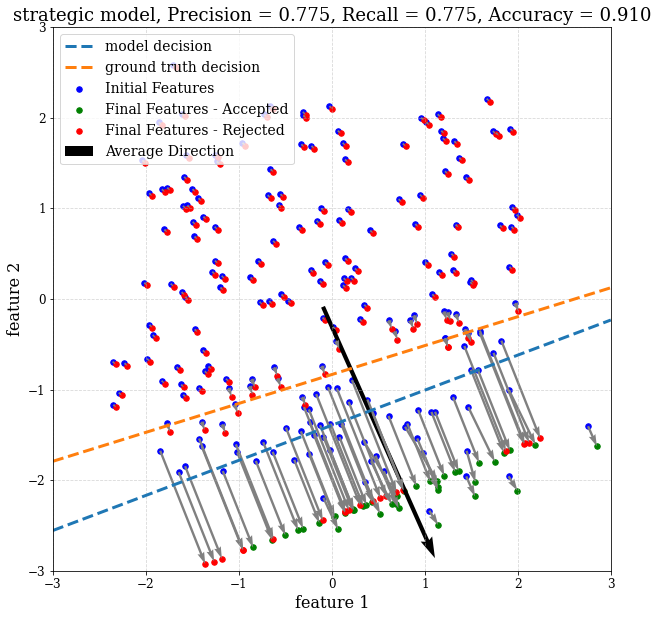

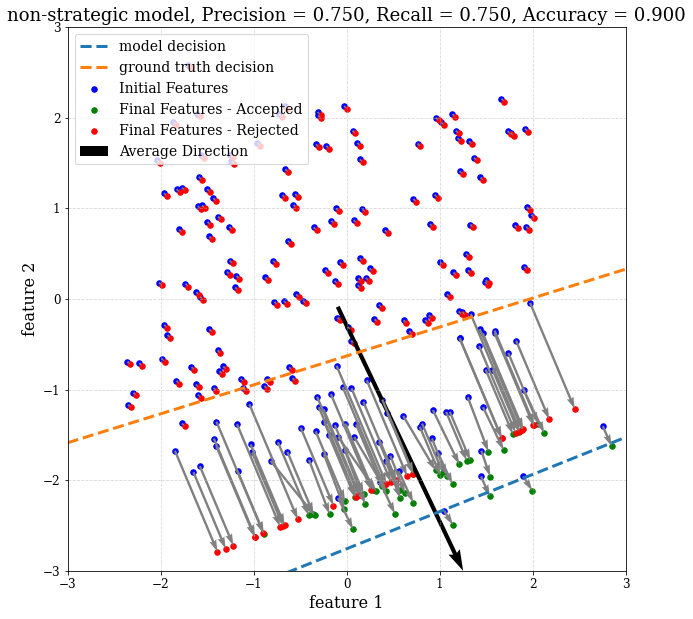

In [28]:
# plot results
print(f'ground truth - preference vector, u = {rank_env.system_attributes}')
print(f'strategic model, w = {rank_env.w}, b = {rank_env.b}')
our_scatter(rank_env, model_strategic, X_test, strategic_test_metrics, title='strategic model', use_lin_search=True, lin_search_sample_num=20)
print(f"strategic model burden = {strategic_test_metrics[strategic_test_metrics['epoch num'] == 9]['burden'].values}")
print(f'non-strategic model, w = {rank_env_non_strategic.w}, b = {rank_env_non_strategic.b}')
our_scatter(rank_env_non_strategic, model_non_strategic, X_test, non_strategic_test_metrics, title='non-strategic model', use_lin_search=True, lin_search_sample_num=20)
print(f"non-strategic model burden = {non_strategic_test_metrics[non_strategic_test_metrics['epoch num'] == 9]['burden'].values}")

#### Figure Explanation 

The figure consists of dots representing features, their place according to their feature values.

The blue dots represent the initial value of the features, i.e. before the strategic users changed them, the green dots are the updated feature values of users which were supposed to get accepted according to the ground truth, and the red dots are the updated feature values of users which were not supposed to get accepted according to the ground truth.

Also, the figure includes 2 lines, representing the model and ground truth descision line directions: The orange line represents the ground truth, while the blue one is the model's.

We also added arrows to show at which direction each user updated his feature values, and the overall average direction represented with the black big arrow.

#### Analysis
We see that the precision, recall and accuracy results are overall the same. For some runs even the non-strategic model gives better results. We believe this happens because the ranking system itself provides some sort of natural defence mechanism against strategic behavior. This is done without specifically encoding this is the model. Because if everyone competes and improves the rating, then the acceptance threshold moves accordingly. This helps the model to still accept the best competitors. 

It is important to note that this model is not fully non-strategic as it actually learns on strategic data. 
In the training process the model simulates the feature update and trained on updated features based on the approximated model used by the strategic model, it is just not included in the derivatives. This means the model doesn't experience strong out-of-distribution (OOD) effects it just isn't explicitly aware of the feature update model.
 
The strategic model sometimes preforms poorly because the optimization is harder in this case. This is elaborated on in the experiment conclusions.


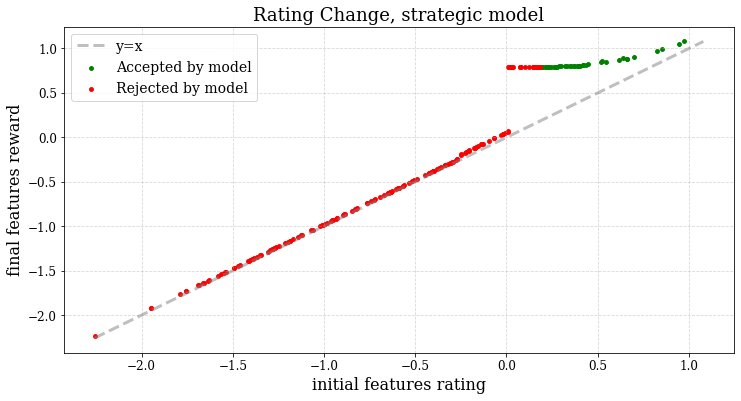

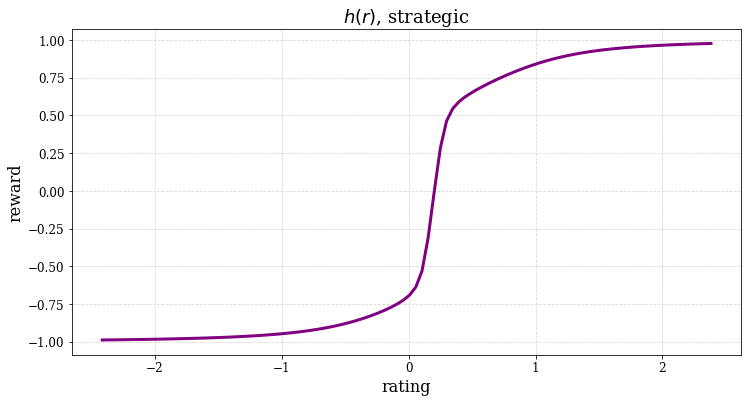

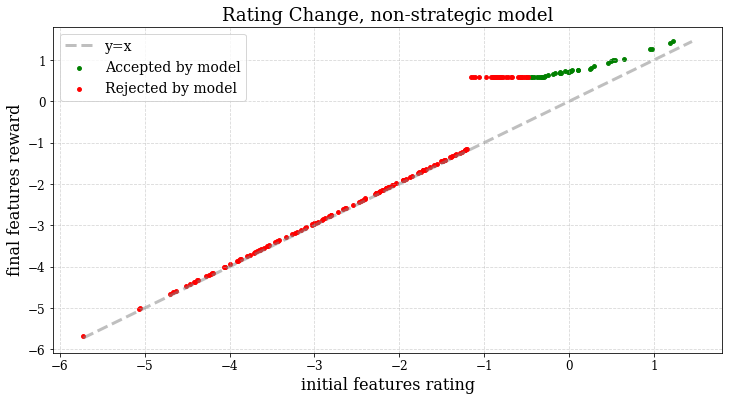

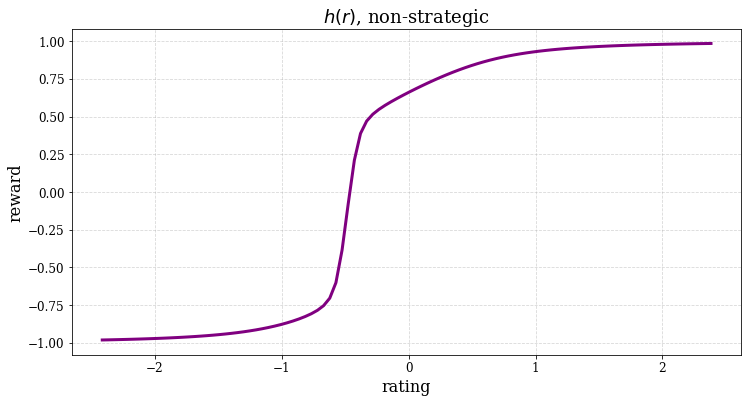

In [29]:
# plotting for the test batch
plot_rating_change(rank_env, model_strategic, X_test, title=f'strategic model')
view_reward_func(rank_env, R_test, X_test, title='strategic')
plot_rating_change(rank_env_non_strategic, model_non_strategic, X_test, title=f'non-strategic model')
view_reward_func(rank_env_non_strategic, R_test, X_test, title='non-strategic')

#### Figure Explanation
This figure demonstrates the change in the features. We see a scatter plot where the x-axis is the model rating that fits initial feature values and the y-axis is the rating that fits the updated feature values. The line $y=x$ is plotted to illustrate how much the ratings where changed. Additionally, we see the reward function $h(r)$ for both models, with thresholds that fit the updated features.

#### Analysis
These graphs actually seem quite similar, we see that the low rated users don't change their initial ratings. This happens until the low threshold is reached and then the users try and pass it, this is shown as a sudden increase in ratings. After this point we see constant ratings and a slower decrease as the initial ratings are higher. This slower decrease is because of the lower slope at the high threshold. We also notice that this helps differentiate between the higher rated users and the lower rated ones.

#### Experiment Conclusion
We concluded that the non-strategic model is more stable and reliable and the added complications in the strategic model to not contribute to the performance. Showing the model simulated strategic data in the train time helped the model learn to adapt to strategic behavior quite well even without accounting for feature update implicitly. Moreover, the strategic model isn't fully differentiable as calculating the low and high thresholds involves a sorting operation and this process is hence excluded from the derivations. This is a critical point as the users intractions is strictly through these thresholds. In further work, it can be important to better include the thresholds in the model predictions.

#### 3.1.2 $ \lVert w \rVert_2 $ as a function of scale

In this part we will check a hypothesis we had: that as the scale grows, the trained weights grow as well.
 
We believe that the main power of the model to respond to strategic behavior is the size of the weight vector. The ground truth preference vector $u$ is normalized and hence it can be described only by a single parameter (the angle). This allows the model to fit the angle and choose the rest of the parameters to combat the strategic behavior. We test this hypothesis by changing the scale parameter (the cost of movement in the feature update). The model should repond such that a low scale (cost) causes little effect to the rating by decreasing the size of $w$.

We will compare the results between the strategic and non-strategic model.

In [27]:
# defining 4 different environments for 4 scales
scales = [0.01, 0.1, 0.5, 1, 2]
slope_val=0.3
w_norms = []

for scale in scales:
    # training with different scale std's
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2,
                'k' : 40,
                'k_tag' : 10,
                'n_users': 200,
                'slope_low' : 0.3,
                'slope_high' : 0.3,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : scale,
                'grid_range' : 0.6,
                'lin_search_sample_num': 30}
    
    rank_env = RankingEnv(**env_params)
    # defining both models
    strategic_model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    non_strategic_model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    path_strategic = f"./tests/scales_test_{scale}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = strategic_model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = strategic_model.total_time
    ccp_time = strategic_model.ccp_time
    w, _ = strategic_model.get_wb()
    total.append(total_time)
    ccp.append(ccp_time)
    # we take the L2(=p)-norm of w
    w_norms.append(float(torch.norm(w, p=2)))

    # saving baseline
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')

    # do the same for the non-strategic model
    path_non_strategic = f"./tests/scales_test_{scale}/non_strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training non-strategic model')
    non_strategic_train_metrics, non_strategic_test_metrics = non_strategic_model.fit(path_non_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = non_strategic_model.total_time
    ccp_time = non_strategic_model.ccp_time
    w, _ = non_strategic_model.get_wb()
    total.append(total_time)
    ccp.append(ccp_time)
    # we take the L2(=p)-norm of w
    w_norms.append(float(torch.norm(w, p=2)))

    # saving baseline
    pd.DataFrame(np.array(total)).to_csv(path_non_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_non_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_non_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_non_strategic + '/test_metrics.csv')

now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 42.1592218875885 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 30.2476167678833 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 48.57503032684326 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 36.33294916152954 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 72.46490573883057 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 59.67904806137085 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 59.46644735336304 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 47.137542724609375 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 50.634392976760864 seconds
now training non-strategic model
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 37.8807168006897 seconds


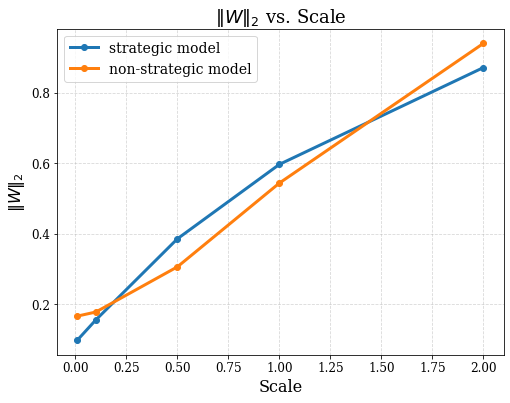

In [21]:
# plotting an appropriate plot for w as a function of scale
strategic_w_norms=w_norms[::2]
non_strategic_w_norms=w_norms[1::2]
plt.plot(scales, strategic_w_norms, marker='o', label='strategic model')
plt.plot(scales, non_strategic_w_norms, marker='o', label='non-strategic model')
plt.title('$\Vert W \Vert_2$ vs. Scale')
plt.xlabel('Scale')
plt.ylabel('$\Vert W \Vert_2$')
plt.legend()
plt.grid(True)
plt.show()
        

#### Analysis and Conclusions
We indeed see that the size of $w$ increase with the scale as we predicted. This happens for both the strategic and non-strategic models. This means that both models succesfully understand the impact of the scale parameter and adjust the model parameters to cope with it. Later in experiment 3.2.2 (changing scales) we show that indeed the at least the non-strategic model achieves good predictive performance for different scales. 


### 3.2 Different contest parameters

Next, we perfomed changes to the contest parameters in order to see how they influence the model, and explore different trends.

As stated above we use the non-strategic model from now on.


#### 3.2.1 Slopes experiments

In those experiment we want to test the model's performance for different slopes.

now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 112.4756851196289 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 97.69012594223022 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 77.5857617855072 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 68.52066993713379 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 62.57877540588379 seconds


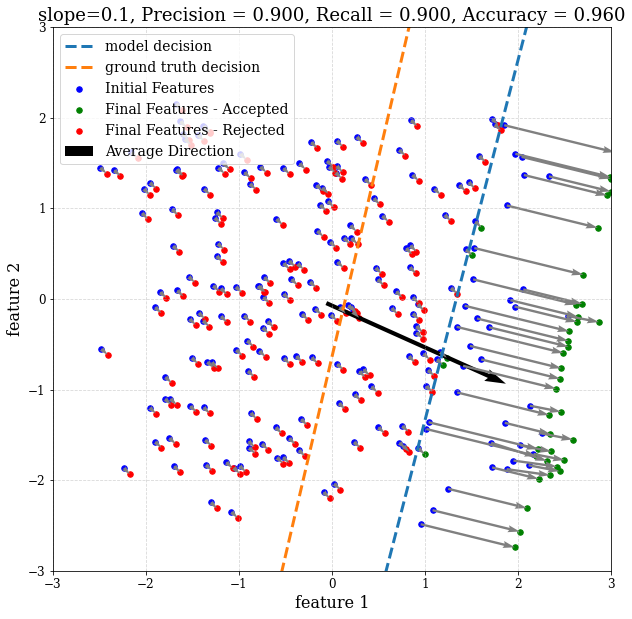

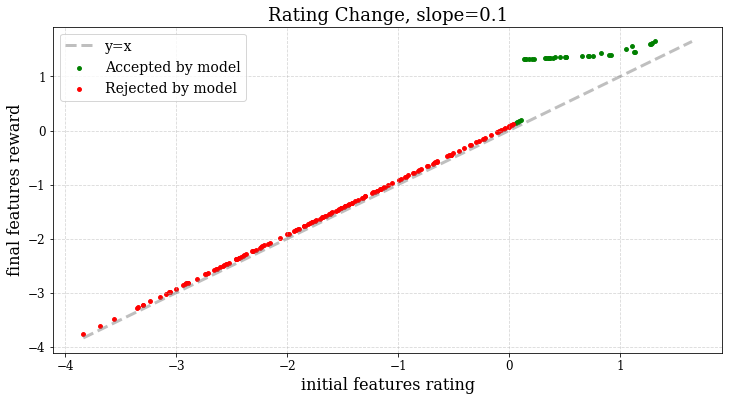

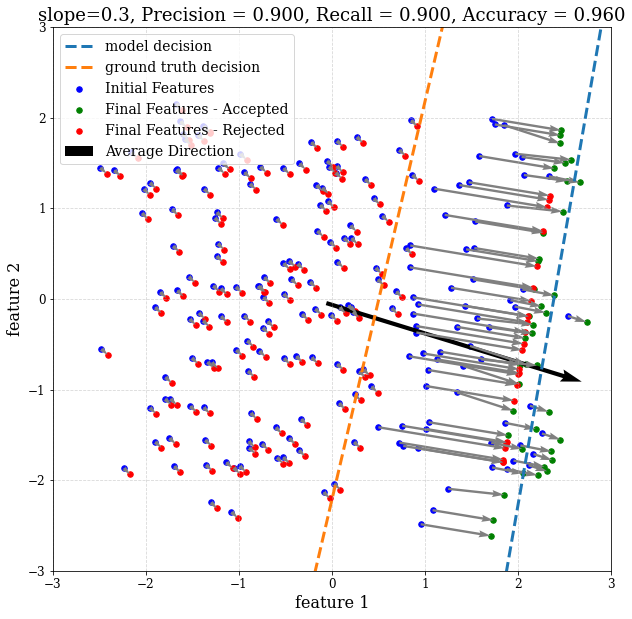

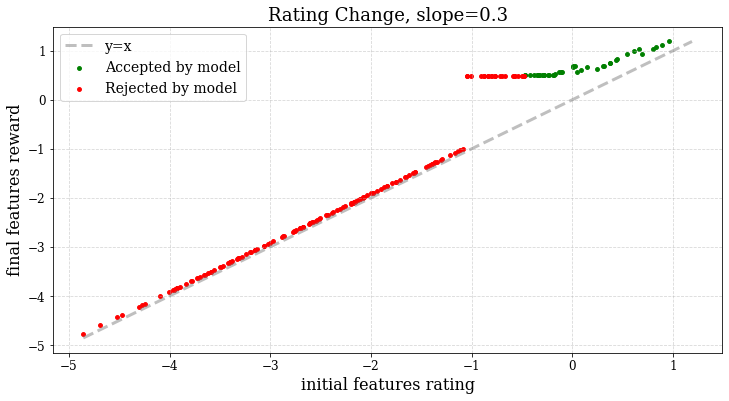

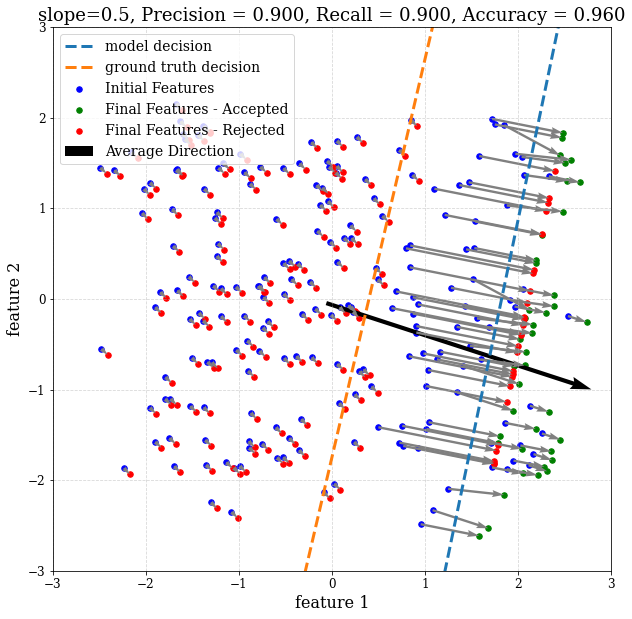

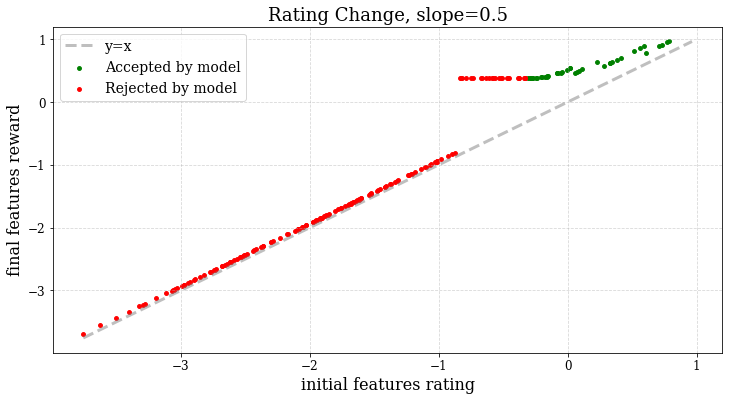

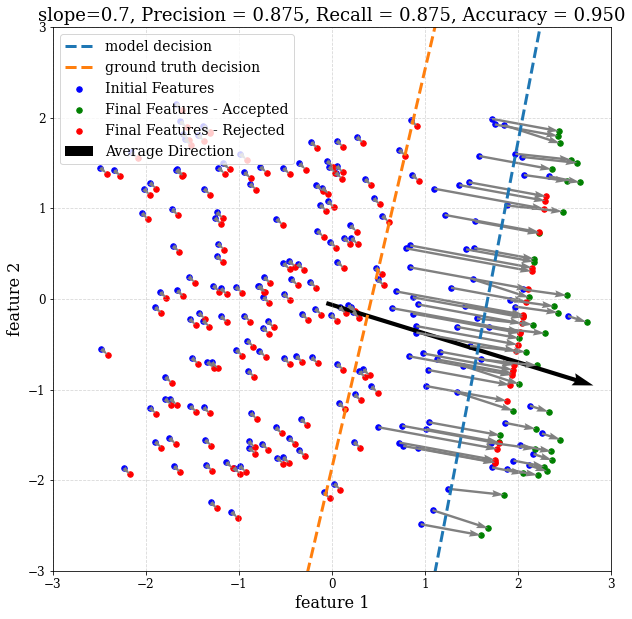

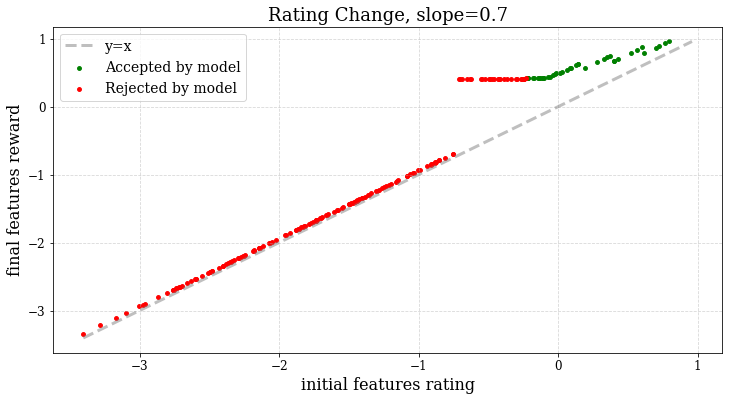

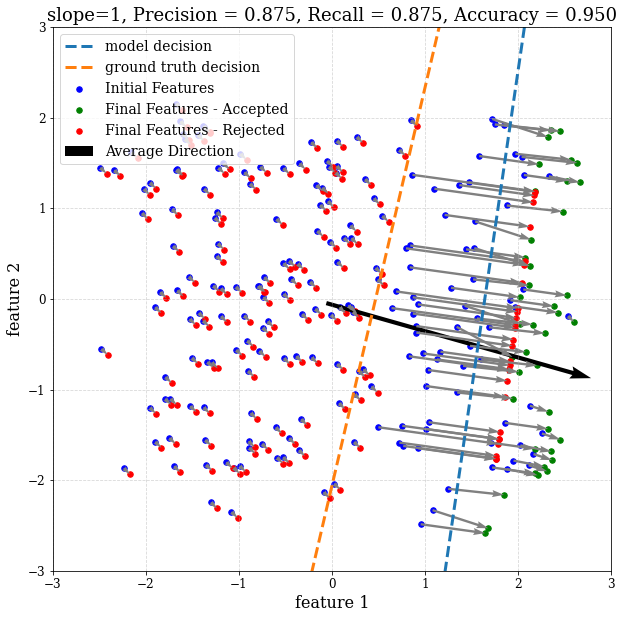

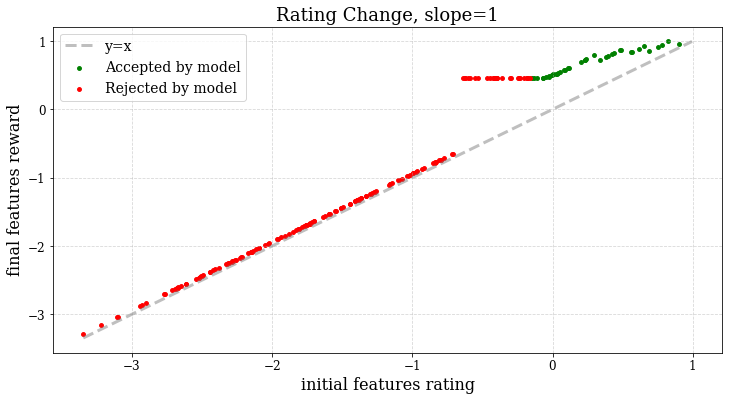

In [19]:
# defining different environments for different slopes
slope_vals = [0.1, 0.3, 0.5, 0.7, 1]
scale = 1

for slope_val in slope_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 10,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    # this time we are working with a non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_slope_test_{slope_str}/non_strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'slope={slope_val}')
    plot_rating_change(rank_env, model, X_test, title=f'slope={slope_val}')
        

#### Conclusion
As the slope increases more and more users choose to approach the threshold and cross it as it becomes more rewarding. Users far from the threshold are not affected, this is because the low slope is high (the step is steep and very local). Hence, near movements don't affect the reward much (the reward is almost zero there). 

#### 3.2.2 Scales experiment

 Next, we wanted to check the effects of scales on the results of the model.
 
 The scale affects the price of changing the features according to distance moved:
 
 $$c(x,x_t)=\text{scale}\cdot\lVert x-x_t \rVert ^2$$
 
 **Note:** We've seen so far that the non-strategic model had the same or (in few cases) better results than the strategic one.
 
 Therefore from this experiment we will by default run on the non-strategic model (unless we want to compare it to the strategic model).

now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 83.85776042938232 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 126.87274312973022 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 127.0576901435852 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 116.94379115104675 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 95.59257292747498 seconds


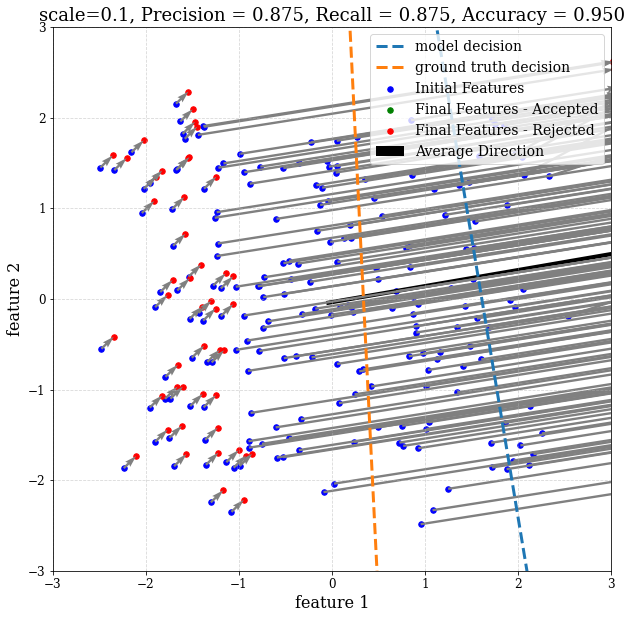

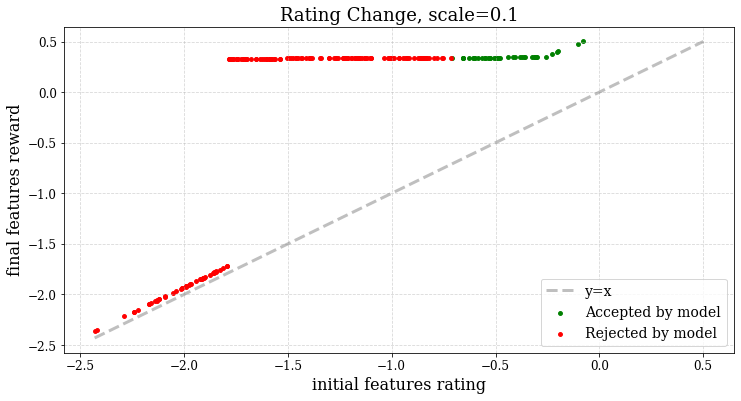

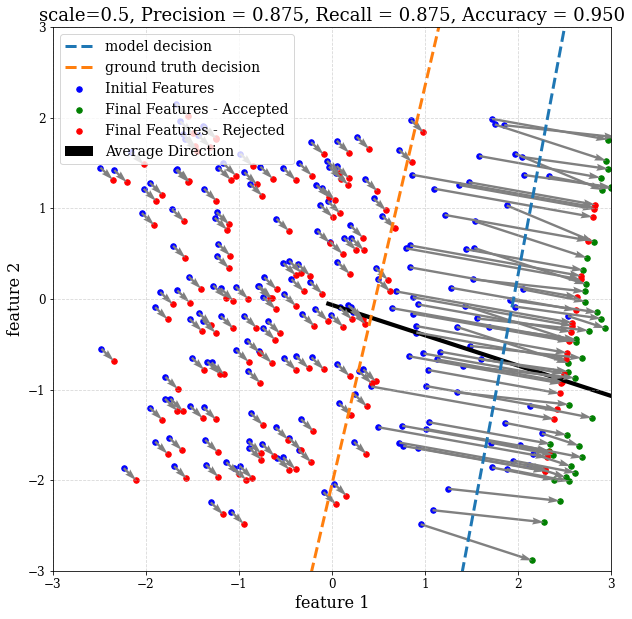

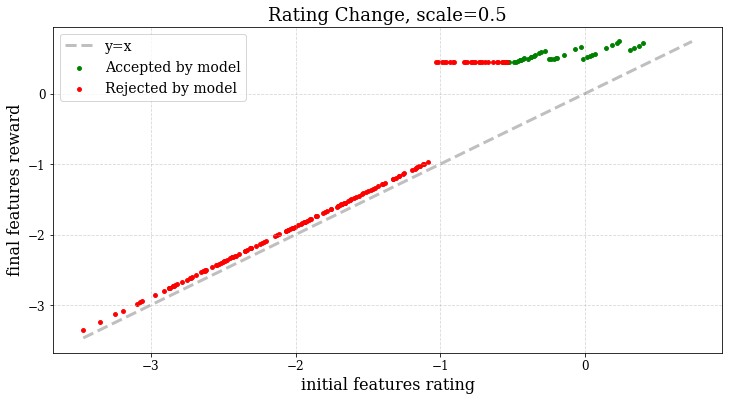

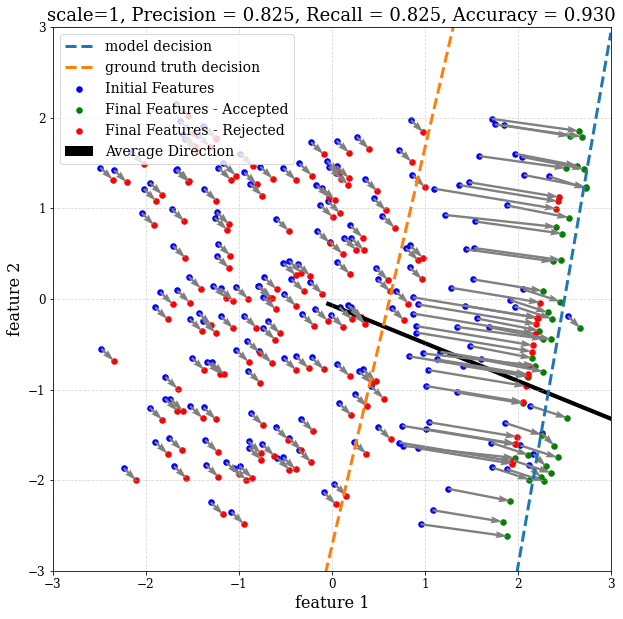

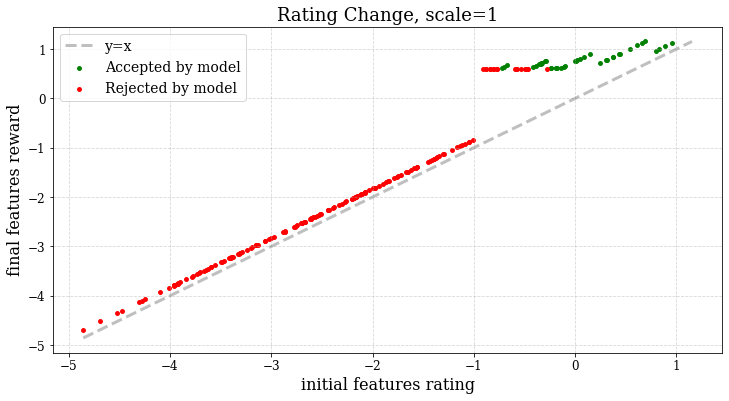

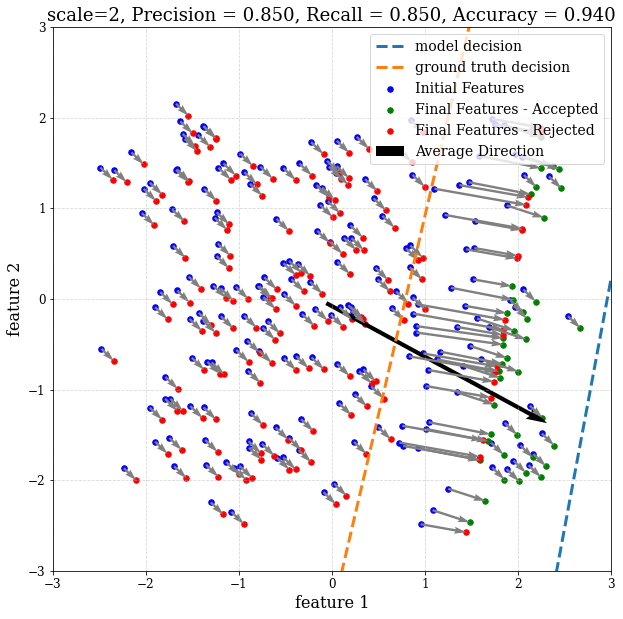

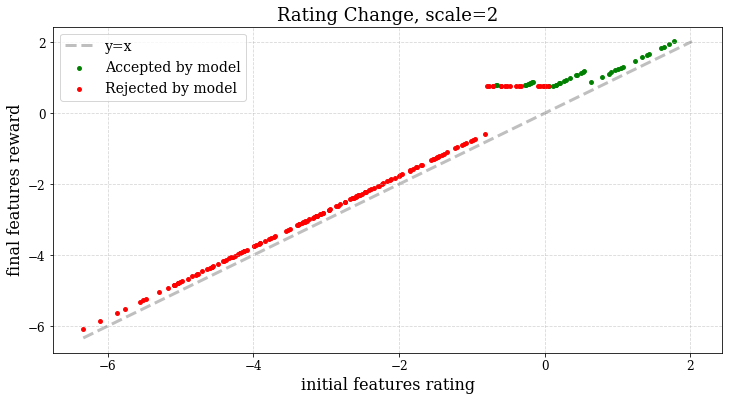

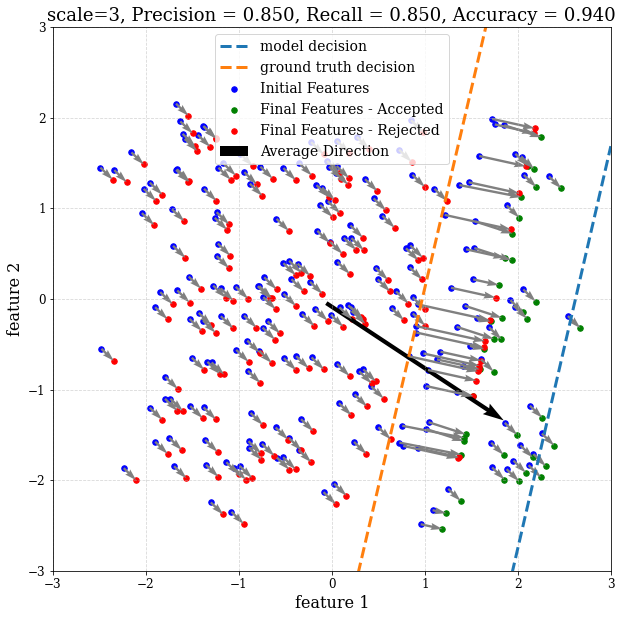

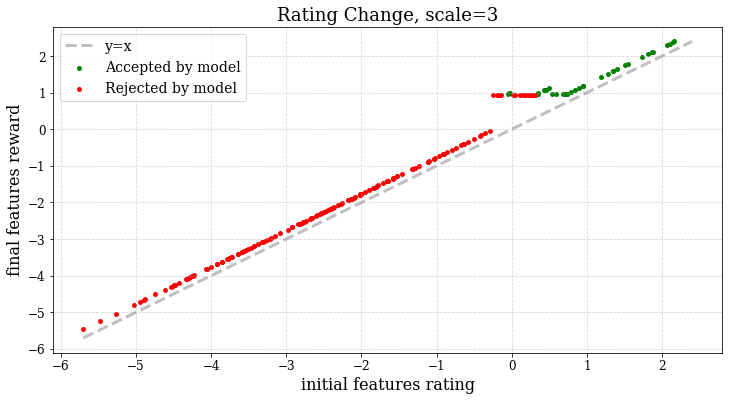

In [26]:
# defining different environments for different slopes
slope_val = 0.3
scale_vals = [0.1, 0.5, 1, 2, 3]

for scale in scale_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 10,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'grid_range': 0.6,
                'lin_search_sample_num': 30}
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    scale_str = str(scale).replace('.', ',')
    path_strategic = f"./tests/2d_scale_test_{scale_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'scale={scale}')
    plot_rating_change(rank_env, model, X_test, title=f'scale={scale}')

#### Conclusion
As expected the users move more as the scale decreases (less cost for movement). We can see that when the cost is low even very far users move to the threshold line since the movement cost is low for them. When the cost increases we can see that the movements become smaller. Surprisingly, we see that the predictive performance is still good even when the scale is very low and the users move a lot. This is because the scales are uniform for all users and hence the better users are able to maintain their advantage by increasing their features slightly. This is an example of the user interaction in this system, the good users respond by a slight increase. 

If the scale where different between the users or the users weren't able to observe the acceptance threshold directly we would expect the performance to drop. We show an experience with users with different scale in the end of this notebook.

#### 3.2.3 K experiment 
Now we change the value of $k$, the number of accepted users in the experiment. This determines the low threshold in the behavioral reward function $h(r;\phi)$ for the strategic response model $\Delta_h(\cdot)$.

**Note**: We fixed $k'=\text{round}(k/2)$.

now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 111.8193895816803 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 112.84253215789795 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 105.20281434059143 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 96.94249558448792 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 89.78718948364258 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\problems\problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
model saved!
model saved!
model saved!
model saved!
training time: 70.1833484172821 seconds


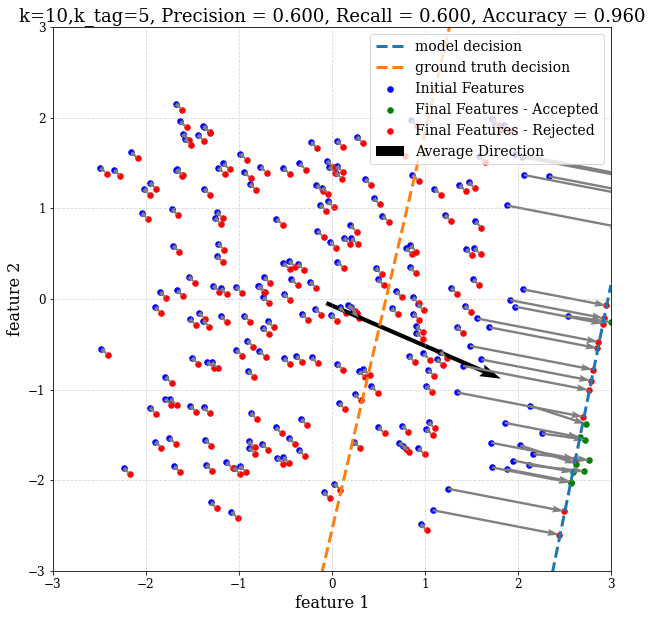

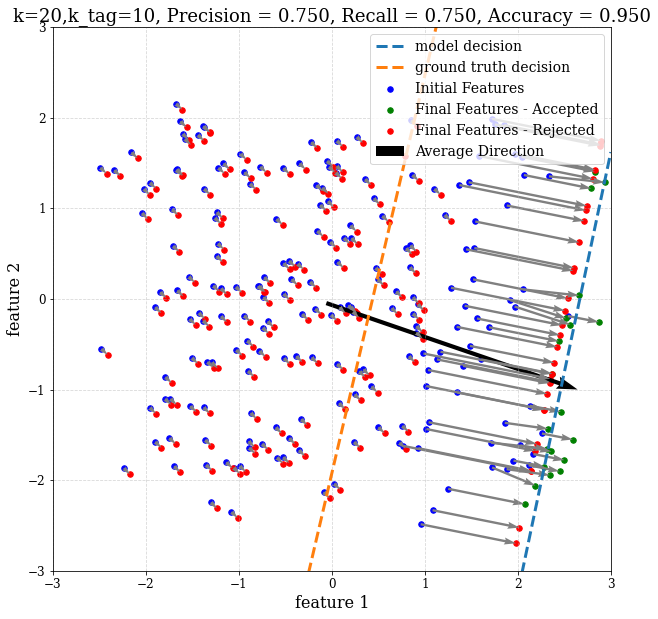

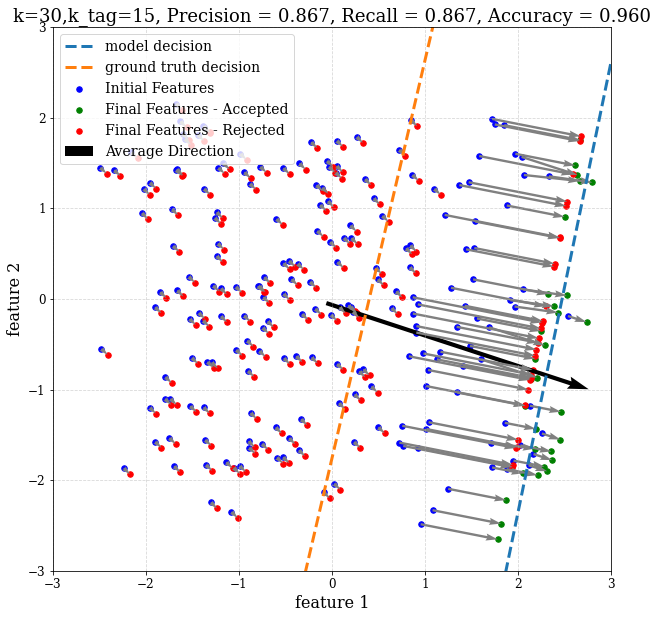

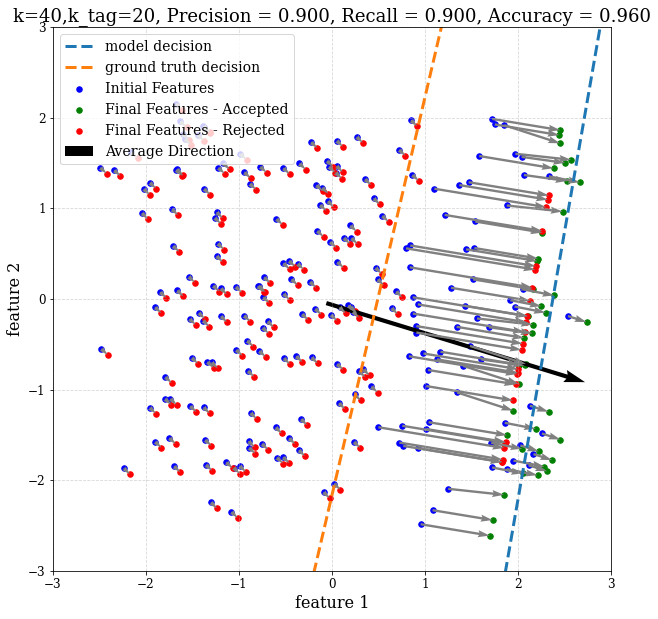

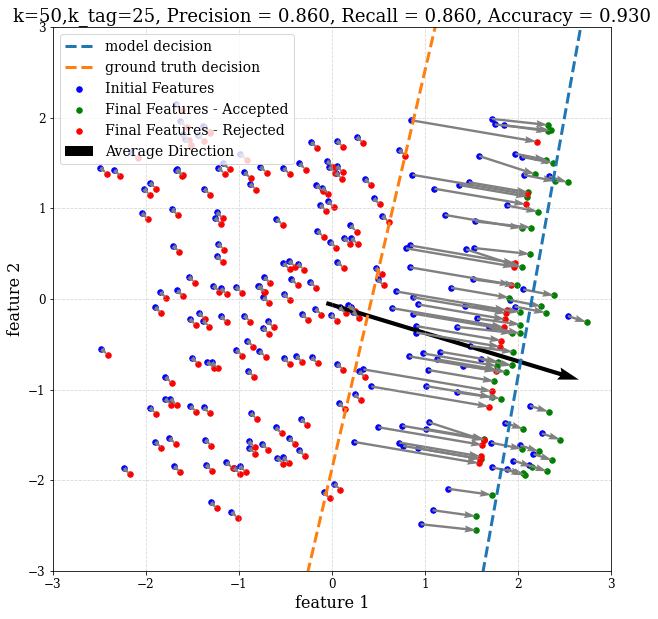

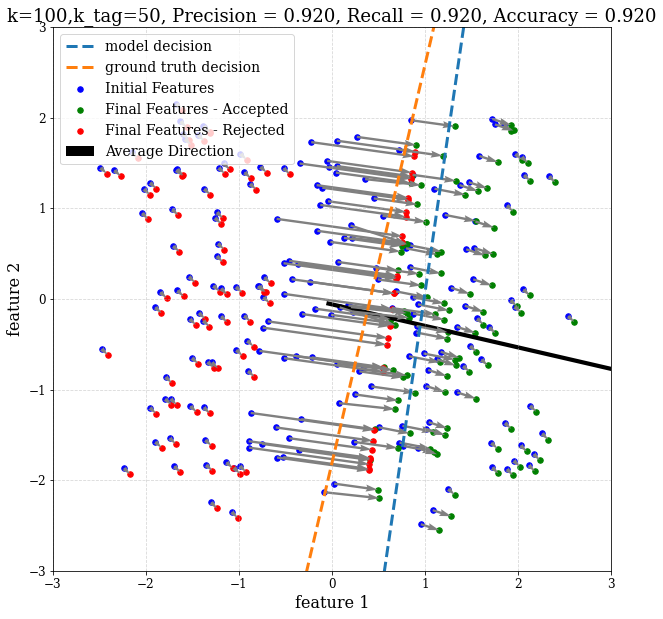

In [33]:
# defining different environments for different slopes
slope_val = 0.3
scale = 1
k_vals = [10, 20, 30, 40, 50, 100]

for k in k_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : k,
                'k_tag' : k // 2,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : scale,
                'n_batch' : 5}
    
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var()
    rank_env.set_scale(scale / (feature_var))

    k_str = str(k).replace('.', ',')
    path_strategic = f"./tests/2d_test_k_{k_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'k={k},k_tag={k // 2}')
        

#### Conclusion 
As we have shown before only users near the acceptance threshold change their features drastically. We can think of this as some of the observed features coming from the original uniform distribution (the static users) which are far from the acceptance threshold. And the rest of the observed features come from another distribution affected by the feature change (dynamic users). When $k$ is small we observe fewer samples from the dynamic user distribution and hence the model performs poorly on it. This is expressed by lower precision for lower $k$ values, as the accepted users are dynamic (near threshold). This is not a case of label unbalance as the model doesn't learn to classify but to regress the user rating $r_{\theta}(x)$.  

#### 3.2.4 k' experiment
Now we change the value of $k'$, the number of "strongly accepted" users in the experiment. This determines the high threshold in the behavioral reward function $h(r;\phi)$ for the strategic response model $\Delta_h(\cdot)$.

We fix $k=100$ (to have a long range for $k'$) and change $k'$ to see how it impacts the behavior and performance.

now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 94.87727189064026 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 95.0109395980835 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 95.92812180519104 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\problems\problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


model saved!
model saved!
model saved!
model saved!
model saved!
training time: 110.51274633407593 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 111.6577045917511 seconds


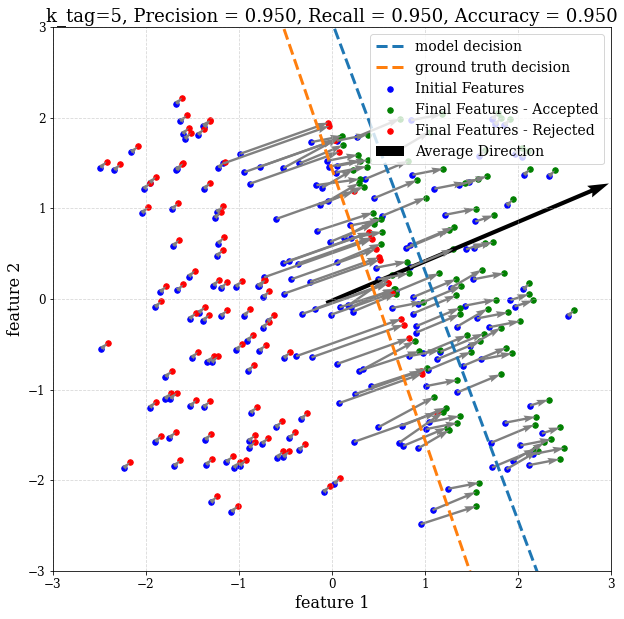

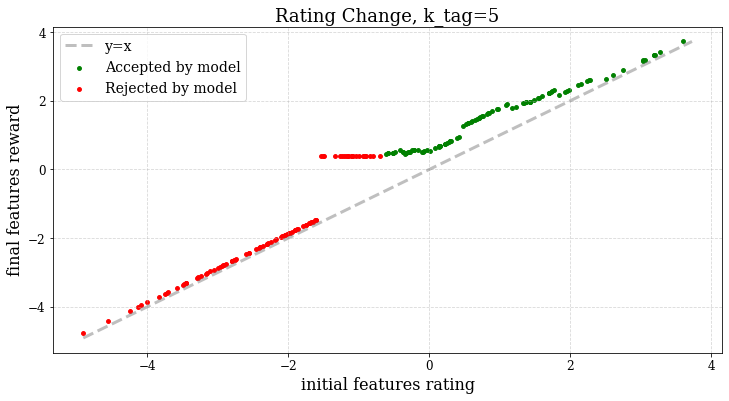

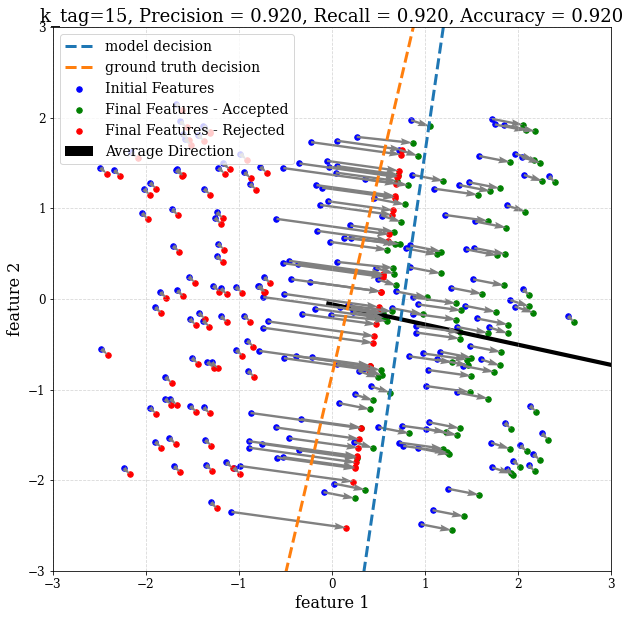

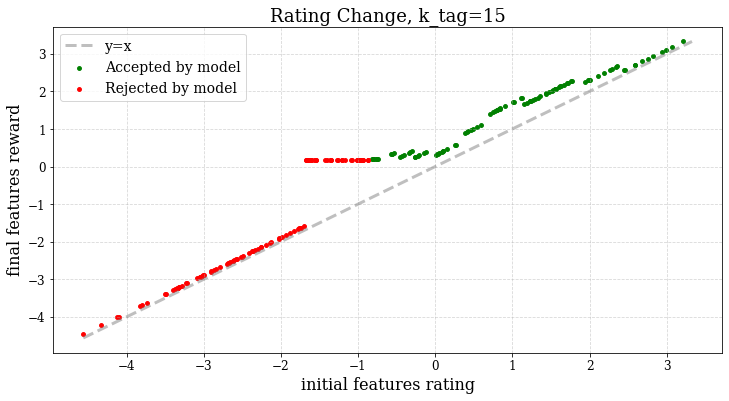

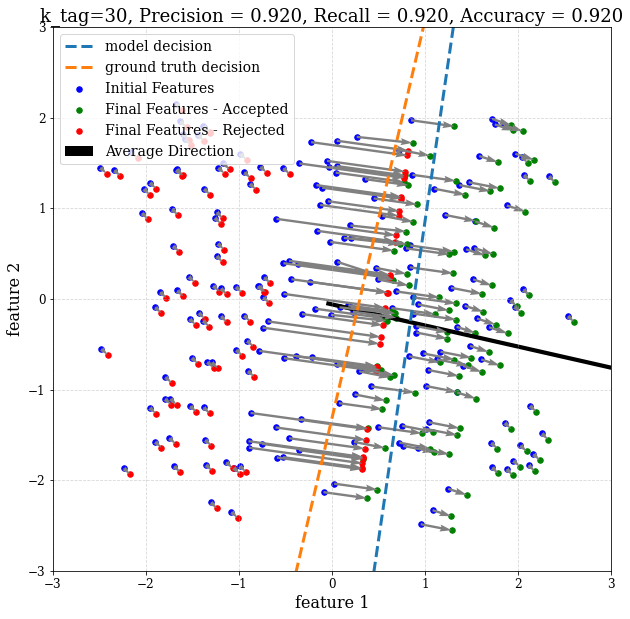

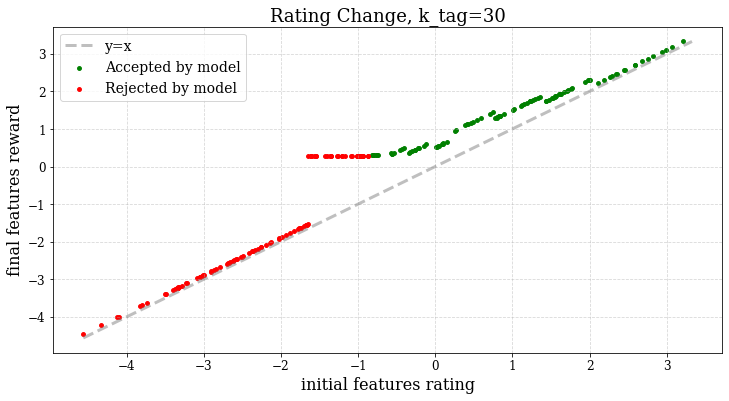

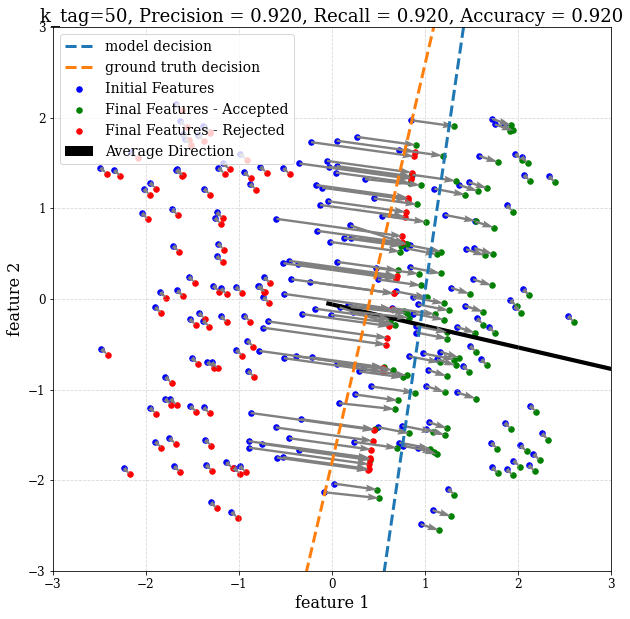

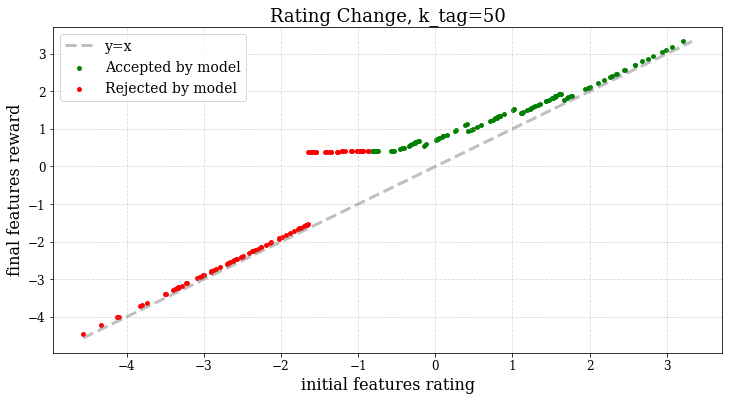

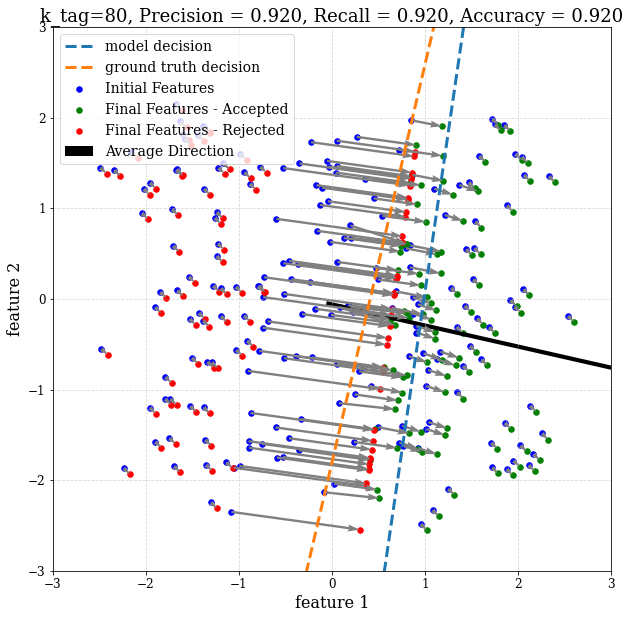

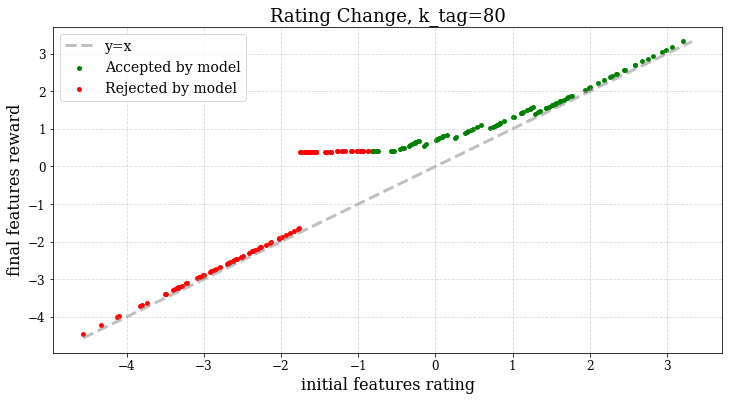

In [29]:
# defining different environments for different slopes
k_tag_vals = [5, 15, 30, 50, 80]
slope_val = 0.3
scale = 1

for k_tag in k_tag_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 100,
                'k_tag' : k_tag,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/2d_test_k_tag_{k_tag}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'k_tag={k_tag}')
    plot_rating_change(rank_env, model, X_test, title=f'k_tag={k_tag}')
        

#### Conclusion
We can see that as $k'$ is smaller the accepted users increase their rating to get closer to the high threshold. When the gap between $k$ and $k'$ is high the user need to work hard to recieve its reward and therefore the user change their features more. This is because the high threshold step is smoother and hence user are rewarded even for moving up the step a little bit and not only for crossing it completely. When the gap between the k and k' is small the smooth step blend in the steep low threshold step and losses most of its impact.

Overall, we don't see a very large impact in k', note that we had to change it very much (5 to 80) to see its effect clearly.  

#### 3.2.5 Acceptance reward experiment

The acceptance reward determines the height of the initial acceptance step in the reward function $h(r;\phi)$. We refered to it previously as $q$ in the strategic behavioral model section 1.3.


now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 90.62224340438843 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 102.6989541053772 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 124.31465673446655 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 118.04535961151123 seconds


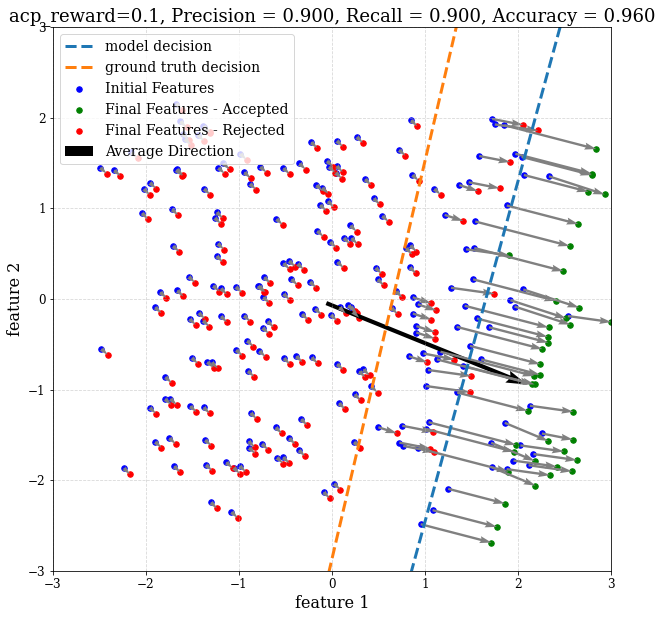

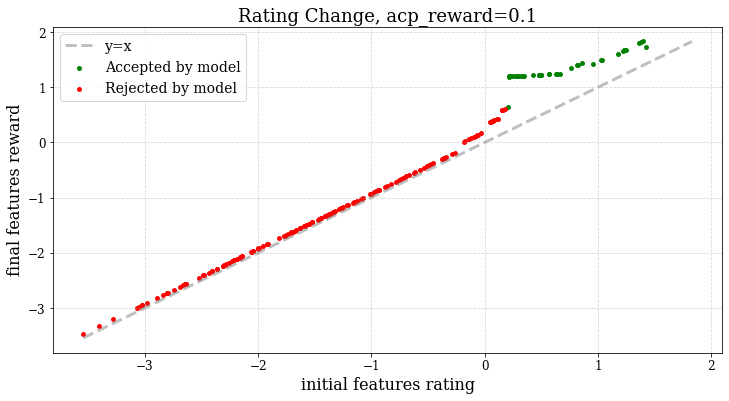

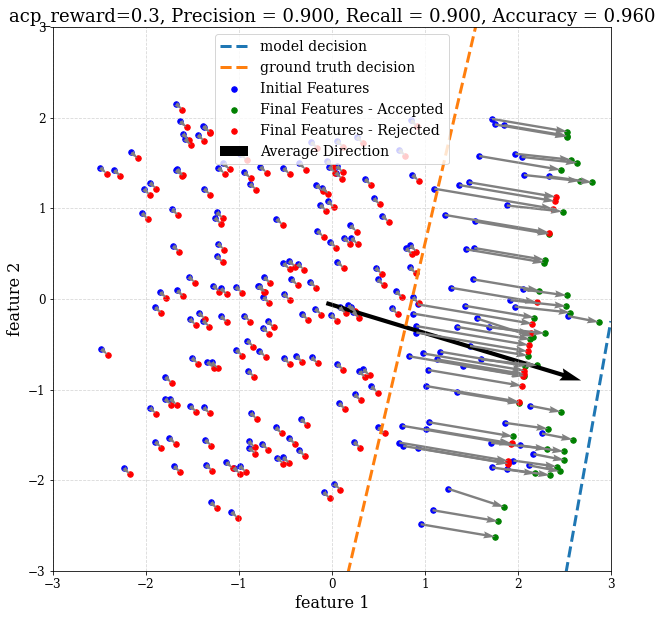

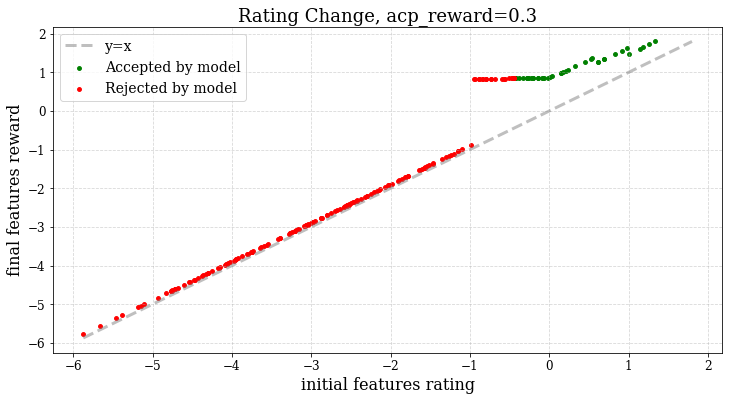

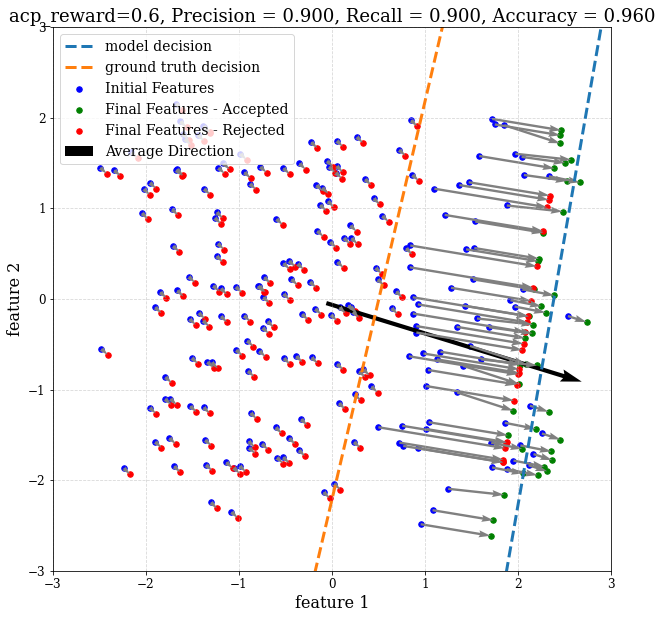

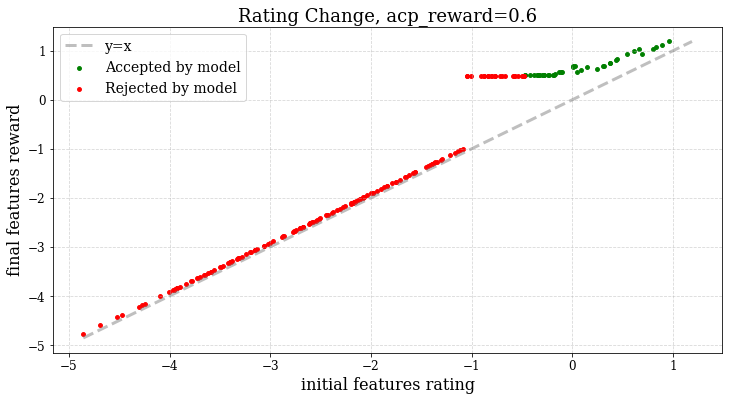

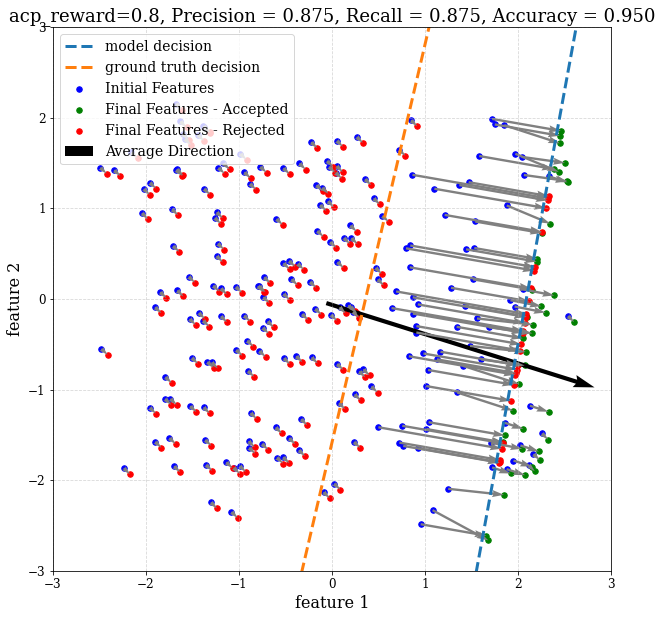

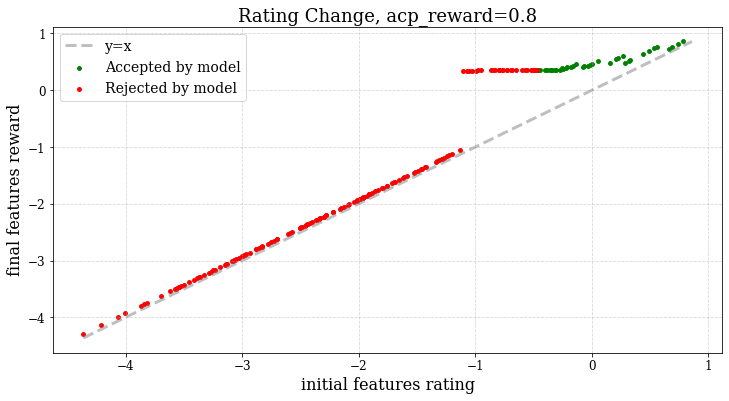

In [20]:
# defining different environments for different slopes
acp_reward_vals = [0.1, 0.3, 0.6, 0.8]
slope_val = 0.3
scale = 1

for acp_reward in acp_reward_vals:
    # training with different slopes for 2 features
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2, # 2 features
                'k' : 40,
                'k_tag' : 10,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : acp_reward,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch' : 5,
                'T_max' : 5}
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True)
    X_test, R_test, y_test = rank_env.generate_dataset(is_test=True, uniform_dist=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))

    acp_str = str(acp_reward).replace('.', ',')
    path_strategic = f"./tests/2d_test_acp_{acp_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'acp_reward={acp_reward}')
    plot_rating_change(rank_env, model, X_test, title=f'acp_reward={acp_reward}')
        

#### Conclusion
We can see that as the acceptance reward increases, more and more users which weren't supposed to get accepted get near the threshhold.
It makes sense, since as the acceptance reward increases, there is more weight on the low threshold slope and therefore it grows steeper, and more users attempt getting past it.

We see that those who can get past the threshhold do so, but those who can't in most cases don't change their features a lot. It only happens when the acceptance rate is the lowest (0.1) that even though they don't pass the threshhold, some users try to get past it (we see that there are couple of red dots which are not at the threshhold level but they have improved their features).

A related effect is that as the accepted reward decreases, the users which already got accepted improve their features even more (even though they got accepted), this is seen by the growing distance of the green dots from the gray line as the acceptance reward decreases.
 

### 3.3 Individual scales

As we've seen, so far our model did pretty well and gave pretty accurate results. We credit this to the fact that all users focus on the threshold and the better users increase their rating a bit to ensure they still get accepted. This behavior seems not very robust and we wanted to challenge it with a more complicated scenario.

Therefore, we wanted to challenge the model a bit more: we added the option that each user will have its own scale, and therefore will have different cost to change its features. 

It corresponds to real-life scenerios which include different means for different individuals. For example, when getting into a university, those with more money and better resources will have easier time get accepted, as they can fund extra learning and private lessons etc.

Our model is not aware of the individual scales, and it assumes that all user have the same scale with is the mean of the scales distribution. In train time as before it simulates the features update with a uniform scale and at test time it is evaluated on individual scales.

It is unclear how to incorporate individual scales in the model itself, especially since we saw that differentiating the strategic response model isn't very helpful.


now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 121.8295373916626 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 115.089510679245 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 131.8846344947815 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 118.15824222564697 seconds
now training strategic model


C:\Users\barw1\anaconda3\envs\ranked_sc\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
model saved!
training time: 126.02702856063843 seconds


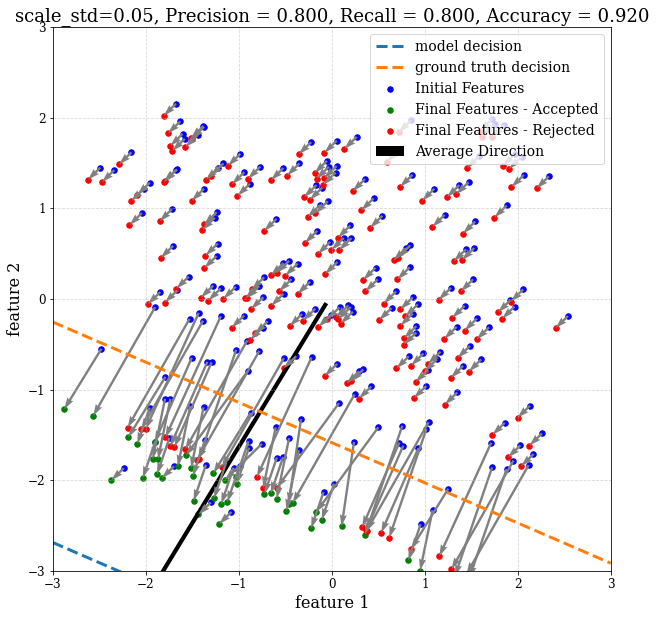

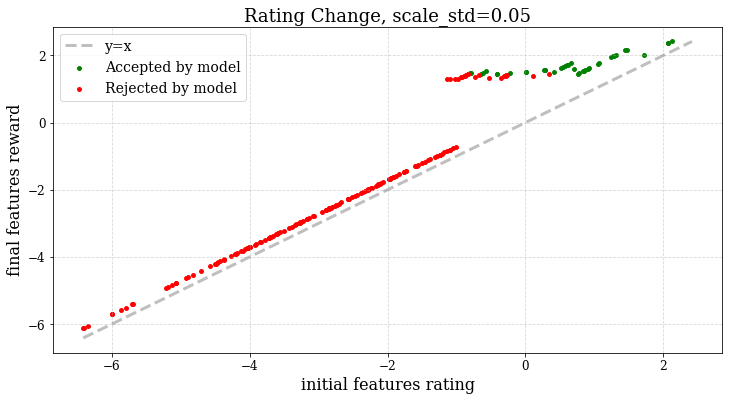

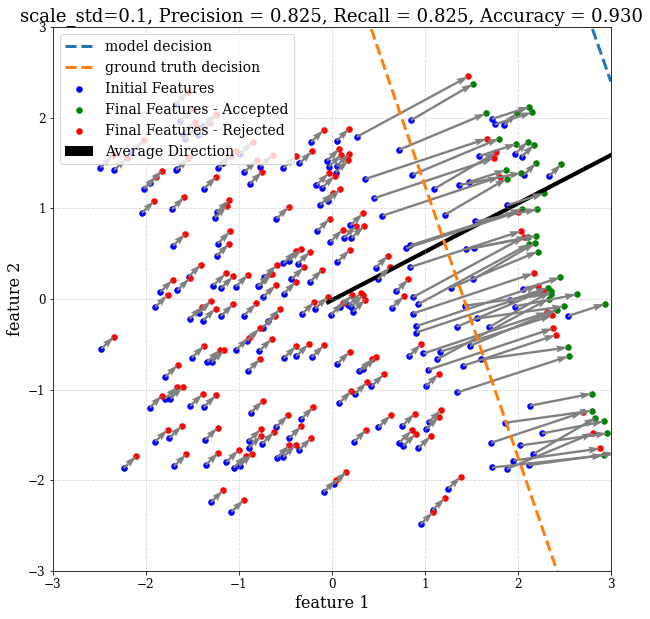

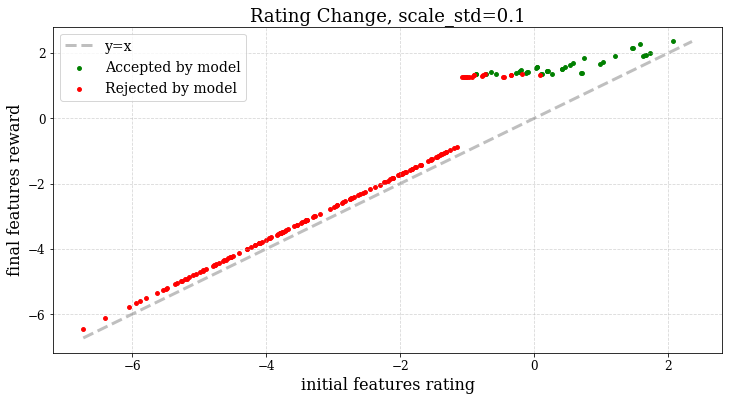

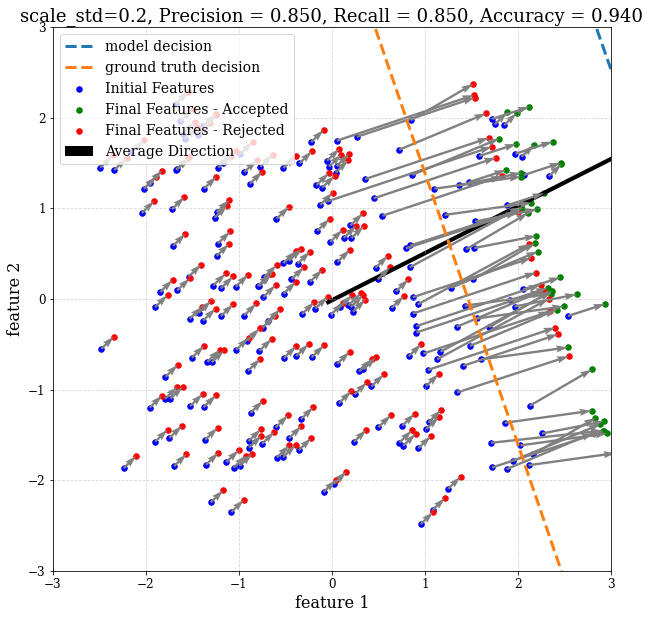

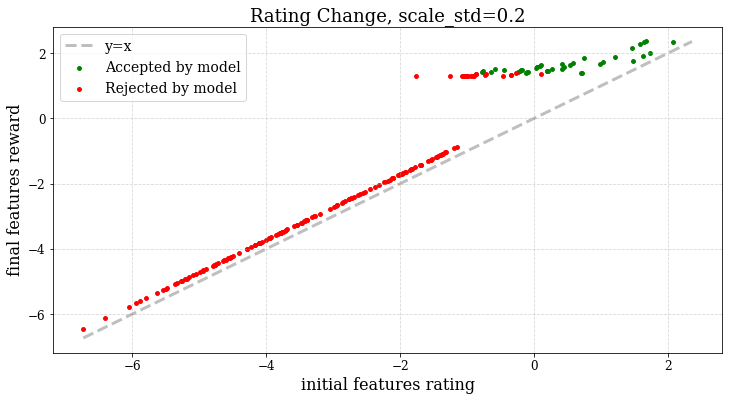

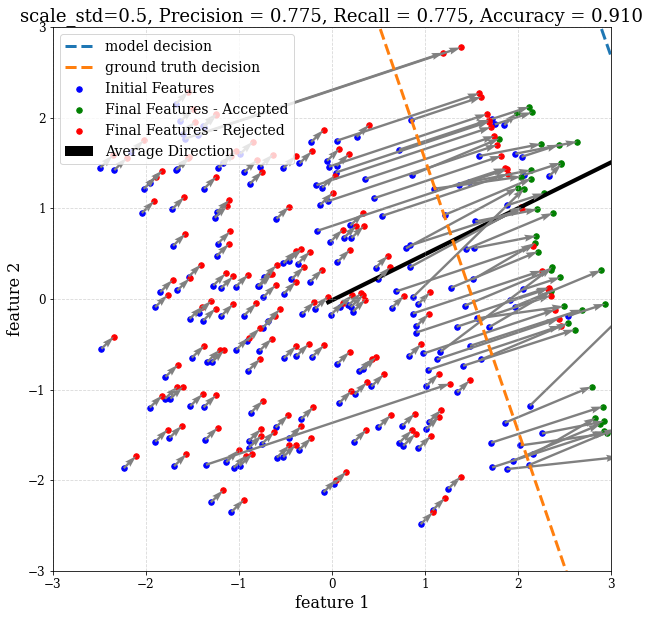

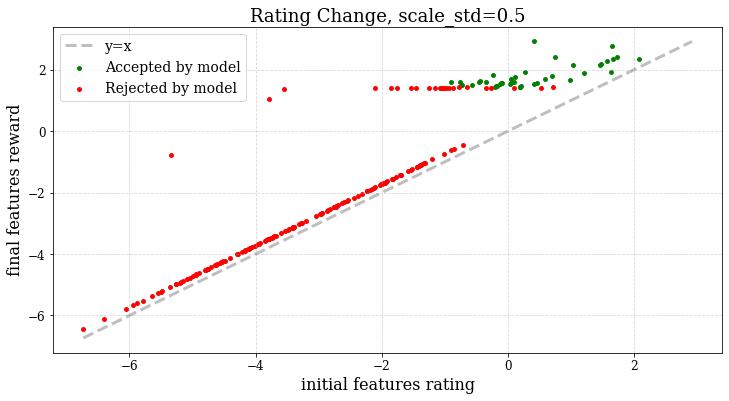

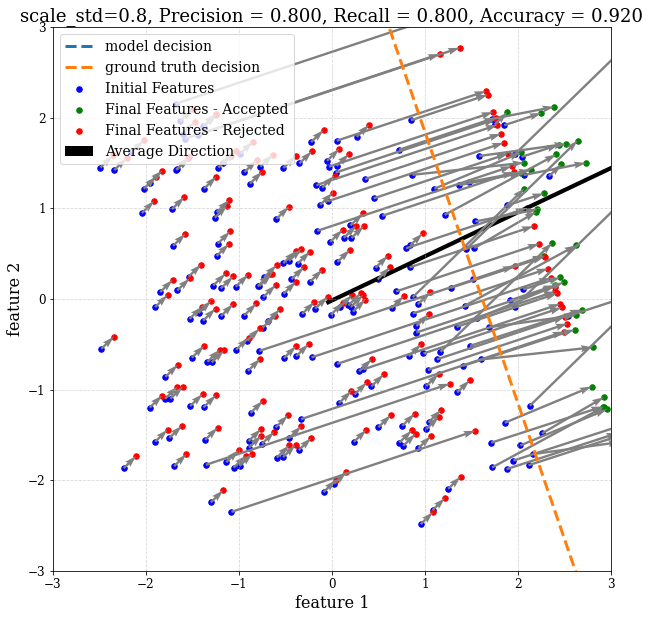

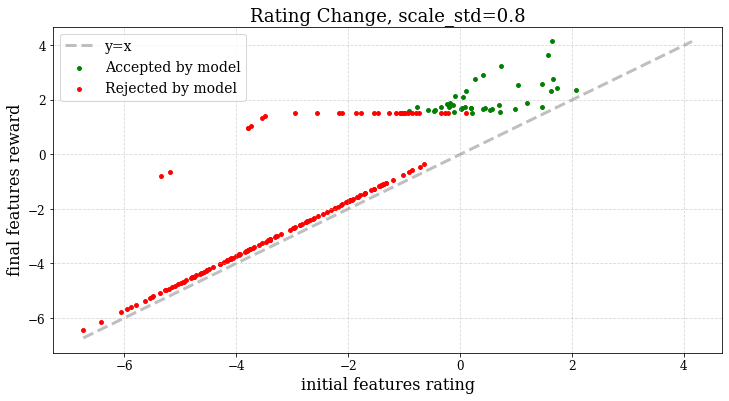

In [28]:
# defining 3 different environments for 3 std's
# defining different environments for different slopes
scale_stds = [0.05, 0.1, 0.2, 0.5, 0.8]
slope_val = 0.3
scale = 2

for scale_std in scale_stds:
    # training with different scale std's
    env_params = {'rating_noise' : 0,
                'feature_noise' : 0.3,
                'n_features' : 2,
                'k' : 40,
                'k_tag' : 10,
                'n_users': 200,
                'slope_low' : 0.3,
                'slope_high' : 0.3,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1,
                'n_batch': 5,
                'scale_std': scale_std,
                'grid_range': 0.6,
                'lin_search_sample_num': 30}
    
    rank_env = RankingEnv(**env_params)
    # defining non-strategic model
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
    
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset(is_test=False, uniform_dist=True, indivdual_scale=True)
    X_test, R_test, y_test, scales = rank_env.generate_dataset(is_test=True, uniform_dist=True, indivdual_scale=True)
    
    # set slope_val and scale to fit the rating range
    rating_range = R_train.max() - R_train.min()
    rating_range = rating_range.detach().numpy()
    rank_env.set_slope(rating_range*slope_val*10, rating_range*slope_val)
    feature_var = X_train.var() 
    rank_env.set_scale(scale / (feature_var))
    scales = scales / feature_var
    
    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/diff_scales_std_test_{scale_std}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        epochs=epochs, verbose=VERBOSE,
                    comment="batched", scales_test=scales)

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)
    
    
    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
    
    # plotting an appropriate scatter plot
    our_scatter(rank_env, model, X_test, test_metrics=pd.DataFrame(strategic_test_metrics), title=f'scale_std={scale_std}', scales=scales)
    plot_rating_change(rank_env, model, X_test, title=f'scale_std={scale_std}', scales=scales)
    

#### Analysis and Conclusion
The feature update scatter plot is a little messy and it is unclear to conclude from it alone, so we will mainly refer to the rating update plot.

In the rating update plot, we can see that the ratings don't increase monotonously anymore. This is because all users are not equal and some can get a-head of other user even if they had a better starting point (initial features). This plot now seems more noisy as the scale isn't displayed here and adds a noisy (random) effect.

We can see two trend lines in the rating change figures. The first one consists of users who are far from the threshold and do not have large enough scale in order to overcome it, thus they do not change their features and remain close to the linear line. The second trend consists of users who do try to move towards the threshold. We can see that the second trend line starts much earlier than before, from worse starting points, as there are users for whom the scale is low and thus compensates for the bad starting points. As the *scale_std* value gets higher second trend line starts earlier as there are more users with exceptionally small scales.

In the feature change figure, we can see that users who chose to increase their features even though they had good rating keep their acceptance classification. This can mean that the desire to excel because of the $k'$ induced effect can help combat these individual scales. We ran a short experiment with different values of $k'$ but since the effect of $k'$ is overll quite small we only saw a slight increase in precision and decided to exclude this experiment.

## 4. Overall Conclusions and Further Work
### 4.1. Conclusions

We explored a setting for strategic classification with user interactions via a ranking system. We think that we suggest a nice framework that includes a behavioral model incorporated with the strategic responses. The model has many parameters that can be tuned as we have done to look at a variety of possible contest settings.

We also saw that the contest itself can be a nice way to combat strategic behavior. If all users act strategically then if they compete with each other in some sense the strategic behavior cancels out. For example, in the class we saw that in classic strategic classification the model decides to move the acceptance threshold. In the ranking scenario this happens by design by sorting the users and setting the acceptance threshold based on that. We believe that this point contributed to the fact that the strategic model did not improve much on the non-strategic model. To continue in this direction it can be interesting to design another rule (like the contest) that encorages users to behave non-strategically. 

We tested the effect of all contest parameters on both the behavior of the user and the predictive performance of the model.

We observed that users tend to locate near the acceptance threshold with little differences in their rating values. We thought that this isn't a very robust behavior for the model's prediction and wanted to challenge that. To do so we introduced individual scales which the model wasn't aware of. We did see that the model is sensitive to this change and we saw a performance drop. We think this can be an interesting step in modeling a more complex setting.   




### 4.2 Further Work
1. Strategic model - We saw that simulating strategic responses in the training data helps cope with strategic behavior. Even without explicitly using the strategic response model for gradient updates. This was a little bit of a let-down as we expected it to improve the results. We suggest a few ideas to improve the strategic model:
    - Including $T_{low}, T_{high}$ in the model descision and optimization. We thought about maybe trying to estimate the threshold in the next dynamic step. This can be done with some sequential model, spline interpolation or even by using a tracking algorithm such Kalman Filter.
    - The model may need more expressivity to deal with actual strategic behavior. We showed that the main power to combat strategic behavior is the norm of $w$. If we use a quadratic layer for instance instead of a linear one, that may give the model more expressive power to handle strategic behavior. Alternatively, more layer can be added with activation functions, but this may harm the convexity required for the CCP and convex optimization layers used to model $\Delta_h(\cdot)$. 
2. Further Settings - As we stated before we showed that the contest itself copes with strategic behavior. There can be more settings to explore that cope with strategic behavior, perhaps with other benefits. Alternatively, enforcing certain properties on the model can potentially help in this regard such as burden regularization or similar ideas.
